# Newland residents’ income predictions

Catarina Natário Moreira (m20201034@novaims.unl.pt), 
João Paulo Guerreiro Aredes César(m20200669@novaims.unl.pt), 
Maikel Sousa (m20200735@novaims.unl.pt)

In [108]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from pandas_profiling import ProfileReport
from math import ceil

# To print colored text
from termcolor import colored
!pip install termcolor

# For feature selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV

# Encoder
from sklearn.preprocessing import OrdinalEncoder

# The dateutil module is an extension to the datetime module. One advantage is that we don't need to 
# pass any parsing code to parse a string.
from dateutil.parser import parse

# Train test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Naive Bayes model
from sklearn.naive_bayes import GaussianNB

# Importing logistic regression:
from sklearn.linear_model import LogisticRegression

# Importing NN regression:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

#Importing Decision Trees:
from sklearn.tree import DecisionTreeClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

#Bagging Classifier
from sklearn.ensemble import BaggingClassifier

#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

#AdaBoost
from sklearn.ensemble import AdaBoostClassifier

#Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier

#Stacking Classifier
from sklearn.ensemble import StackingClassifier

# Importing metrics:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Importing different scalers:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

import time
import statistics

import random

import warnings
warnings.filterwarnings('ignore')

## Data exploration:

Importing of the data:

In [2]:
dfraw = pd.read_excel('Train.xlsx')

# Dataframe copy for exploration:

df = dfraw.copy()

df.head()

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


Instead of keeping a column with the birthday let's create one that contains the age on 2044:

In [3]:
# Getting the age using a parser
Age = df.Birthday.apply(lambda x: parse(x).date())

# Getting the date of each subject by 2044:
Age = Age.apply(lambda X: (parse('01-01-2048').date() - X ).days // 365 )

# Inserting the column in a convinient possition
df.insert(loc=3, column='Age', value=Age.values)

df.head()

,CITIZEN_ID,Name,Birthday,Age,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",44,Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",27,Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",27,Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",27,Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",27,Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CITIZEN_ID,22400.0,23685.500000,6466.467351,12486.0,18085.75,23685.5,29285.25,34885.0
Age,22400.0,30.361786,9.170382,16.0,27.00,27.0,27.00,90.0
Years of Education,22400.0,13.173884,2.512451,2.0,12.00,13.0,15.00,21.0
Working Hours per week,22400.0,40.483795,12.370921,1.0,40.00,40.0,45.00,99.0
Money Received,22400.0,1324.915357,9227.771813,0.0,0.00,0.0,0.00,122999.0
Ticket Price,22400.0,109.145313,500.208904,0.0,0.00,0.0,0.00,5358.0
Income,22400.0,0.237098,0.425313,0.0,0.00,0.0,0.00,1.0


Let's define a list to see to make our analysis easier:

In [5]:
metric_features = df.describe().T.index.to_list()[1:-1]

metric_features

['Age',
 'Years of Education',
 'Working Hours per week',
 'Money Received',
 'Ticket Price']

## Data Cleaning:

Let's clean the test dataset from unwanted records and/or input errors. This will help us improve the performance of the models that we will test:

In [6]:
#To replace '?' values into None values
df_clean = df.copy()
df_clean.replace({'?': None}, inplace=True)

In [7]:
#To check wich variables contains NaN values 
df_clean.isna().sum()

CITIZEN_ID                   0
Name                         0
Birthday                     0
Age                          0
Native Continent             0
Marital Status               0
Lives with                   0
Base Area                  395
Education Level              0
Years of Education           0
Employment Sector         1264
Role                      1271
Working Hours per week       0
Money Received               0
Ticket Price                 0
Income                       0
dtype: int64

As you see above, the columns Employment Sector and Role have almost the same ammount of null values. Let's replace the nan values by the mode in each

In [8]:
df_clean['Base Area'].replace({None: '?'}, inplace=True)

Education_level=df_clean['Education Level'].unique()

for i in Education_level:
    df_fillnan=df[df['Education Level']==i]
    df_clean['Employment Sector'] = df_clean['Employment Sector'].fillna(df_fillnan['Employment Sector'].mode()[0])
    df_clean['Role'] = df_clean['Role'].fillna(df_fillnan['Role'].mode()[0])
    
df_clean.isna().sum()

CITIZEN_ID                0
Name                      0
Birthday                  0
Age                       0
Native Continent          0
Marital Status            0
Lives with                0
Base Area                 0
Education Level           0
Years of Education        0
Employment Sector         0
Role                      0
Working Hours per week    0
Money Received            0
Ticket Price              0
Income                    0
dtype: int64

Acording to the project guidelines we should select only people that are above 17 years old. Let's check the values of people below 18:

In [9]:
df_clean[df_clean['Age']<=17]['Income'].value_counts()

0    222
Name: Income, dtype: int64

#### Reestargint the df_clean dataframe:

In [10]:
df_clean = df_clean[ ( df_clean['Age']>17 ) ].copy()
df_clean.reset_index(inplace = True, drop = True)
#df_clean.replace({'?': None}, inplace=True)
#df_clean.isna().sum()

For the meantime, let's keep the columns with '?' values until is the moment to decide if the columns that contain them are relevant to our models.

## Data Exploration.

To assess the columns to keep in our dataframe let's start exploring each the metrics features.

In [11]:
def correlation(df, corr_type, threshold ):
    """
    To check correlations
    """
    
    # Prepare figure
    fig = plt.figure(figsize=(10, 8))

    # Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
    corr = np.round(df.corr(method = corr_type), decimals=2)

    # Build annotation matrix (values above |threshold| will appear annotated in the plot)
    mask_annot = np.absolute(corr.values) >= threshold
    annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

    # Plot heatmap of the correlation matrix
    sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
                fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

    # Layout
    fig.subplots_adjust(top=0.95)
    fig.suptitle("Correlation Matrix", fontsize=20)

    plt.show()

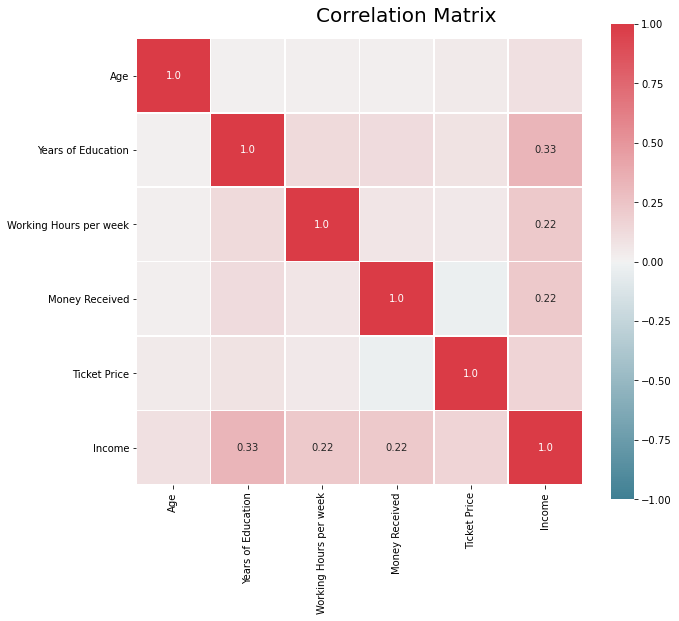

In [12]:
correlation(df_clean[metric_features + ['Income']], 'pearson', 0.2)

By looking at the correlation matrix above we can suspect that the categorical features on our dataset are vital to predict the target variable.

In [13]:
categorical_features = [features for features in df_clean.columns if features not in metric_features ]

# Dropping unwanted columns
for x in ['CITIZEN_ID', 'Birthday', 'Income']:
    categorical_features.remove(x)

From the name column we can get the gender of the person:

In [14]:
name = df_clean["Name"].str.lower()

name = name.str[:4]

titles = name.unique()

print('The titles that we have are: ', titles)

The titles that we have are:  ['mr. ' 'miss' 'mrs.']


In [15]:
# Creating a binary variable:
male = name.apply(lambda x: x in 'mr. ') * 1

categorical_features.remove('Name')

Let's insert information for the gender of the record and determine if it is relevant:

In [16]:
df_clean.insert(loc=4, column='Male', value=male.values)

df_clean.head()

,CITIZEN_ID,Name,Birthday,Age,Male,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",44,1,Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",27,1,Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",27,1,Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",27,1,Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",27,1,Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


Let's check the correlation of our new variable with the rest of the metric features:

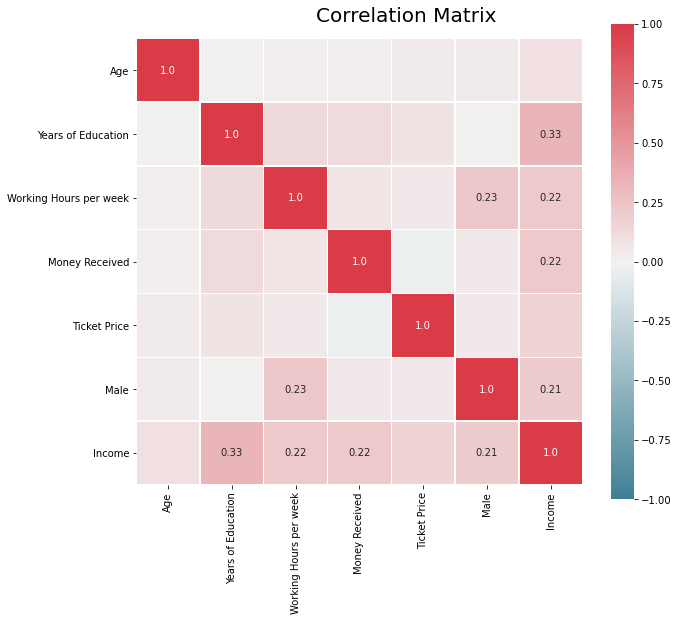

In [17]:
correlation(df_clean[metric_features + ['Male','Income']], 'pearson', 0.2)

Let's see the proportion of the categorical features with the target variable (Income) to also see their relevance when building our ML project:

In [18]:
def proportion_plot( df, column):
    
    # Getting the totals for each value in the column based on the column parameter
    df = (df.groupby([column] + ['Income']).count()['CITIZEN_ID']).reset_index()
    
    # Renaming the column
    df.rename(columns={'CITIZEN_ID':'Proportion'}, inplace=True)
    
    # Pivoting the dataframe to get values in column as index and the values in each proportion as columns based on income
    df = df.pivot(index = column, columns = 'Income', values = 'Proportion')
    
    # Sorting by the ones with bigger income = 1
    df = df.sort_values(by=[1], ascending = True)
    
    df_total = df.copy()
    
    # Getting the proportion of each value in column that are 1 or 0
    for i, sum_ in enumerate(df.sum(axis=1).values):
        df.iloc[i] = df.iloc[i]/sum_
        
    # Sorting by the highest on proportion
    df = df.sort_values(by=[1], ascending = True)
    
    # Creating the plot for the proportions
    df.plot(kind='bar', stacked=True, color=['#C0C0C0', 'black'])
    plt.legend(bbox_to_anchor=(1, 1))
    
    # Setting the title
    Title = 'Proportion of ' + column + ' on Income'
    plt.title( Title, color='black')
    
    # Setting the possition of the legend
    # Add legends (nice to have)
    plt.legend(bbox_to_anchor=(1, 1))
    
    # Creating the plot for the totals
    df_total.plot(kind='bar', stacked=True, color=['#C0C0C0', 'blue'])

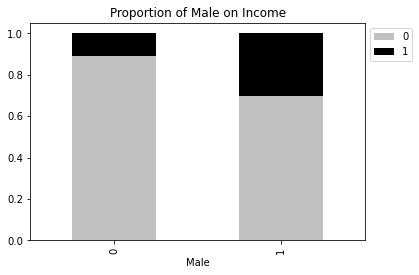

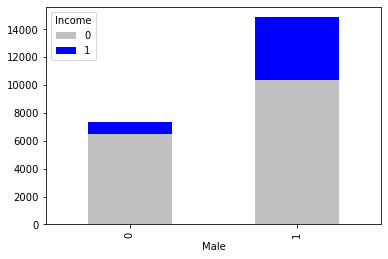

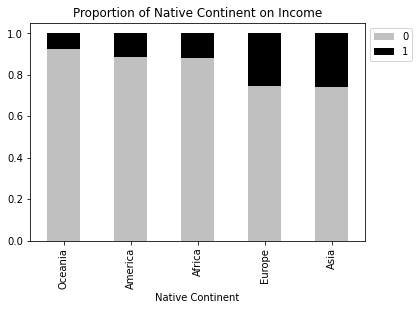

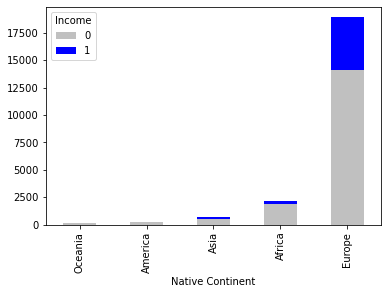

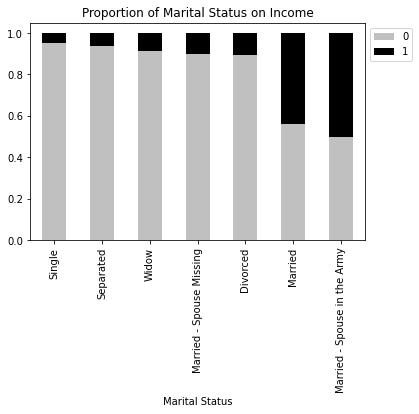

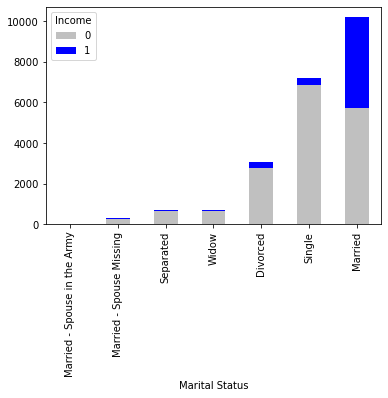

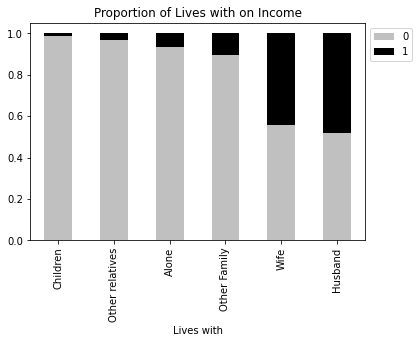

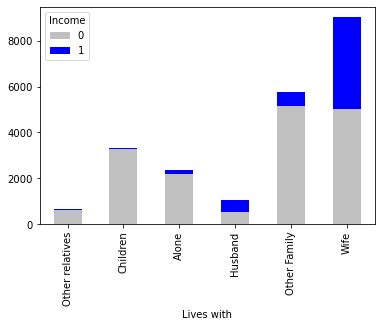

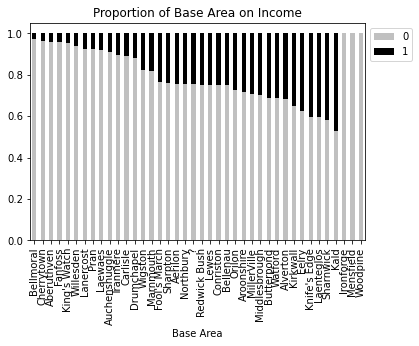

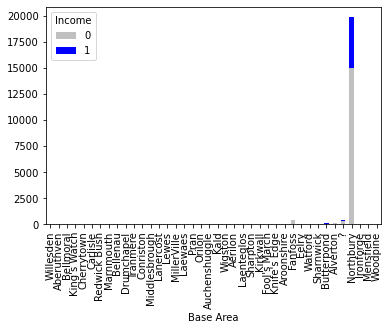

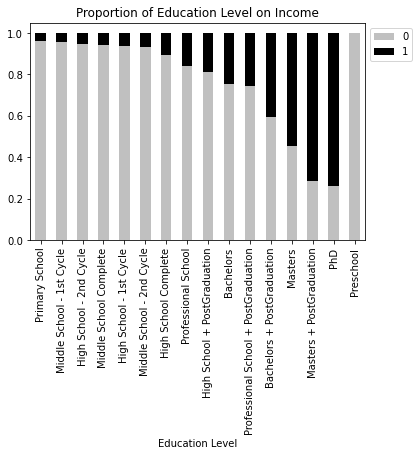

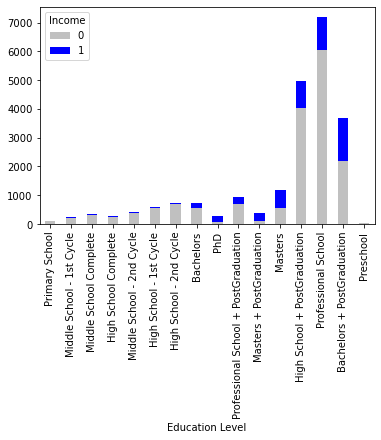

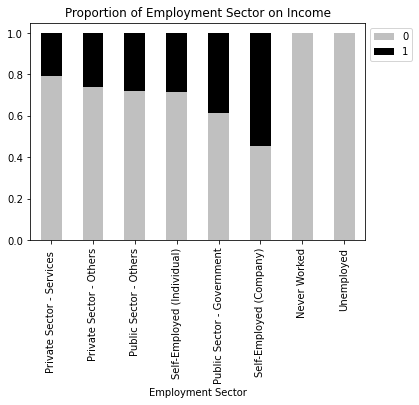

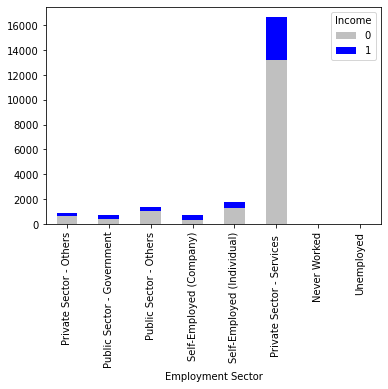

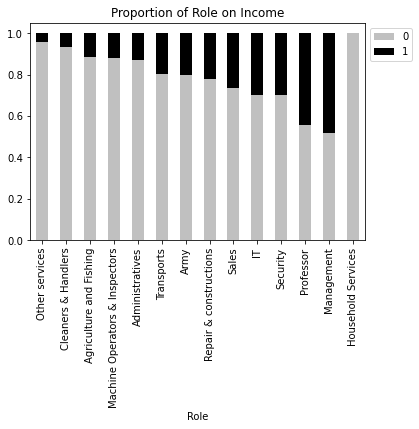

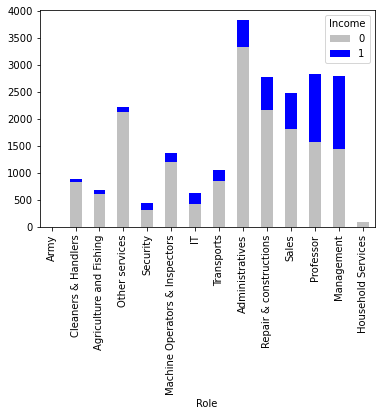

In [19]:
for f in (['Male'] + categorical_features):
    proportion_plot( df_clean, f )

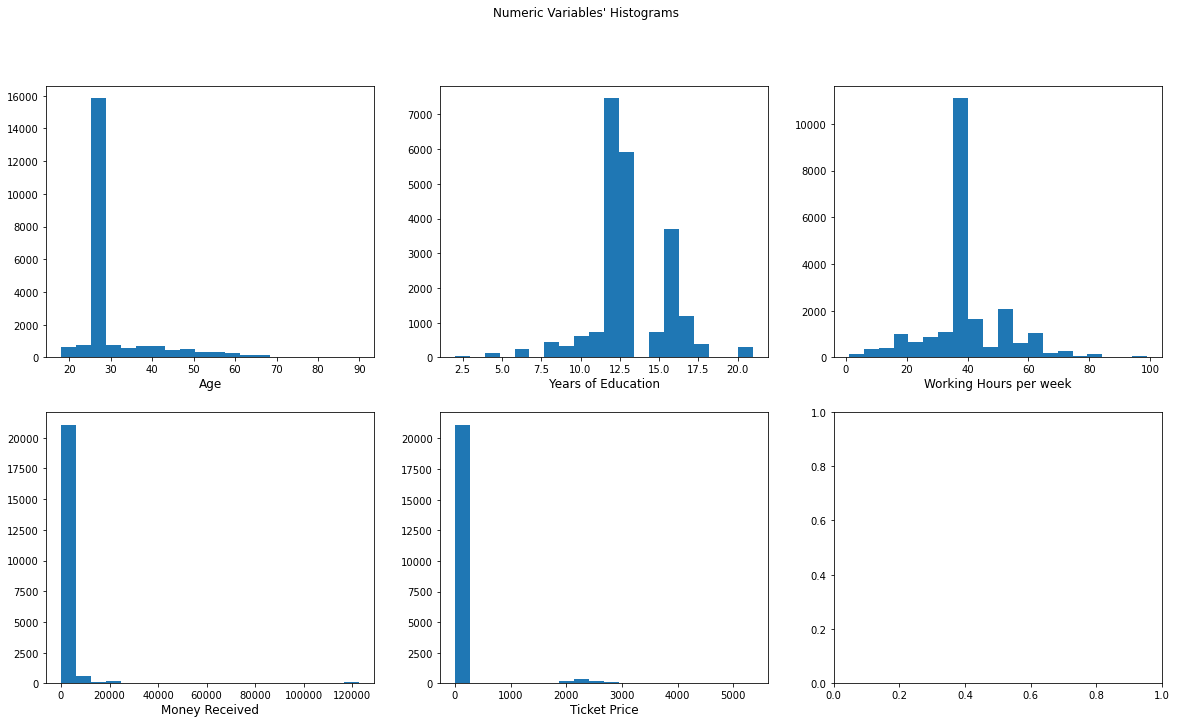

In [20]:
# PLOTTING HISTOGRAMS FOR METRIC FEATURES:

# Prepare figure and Creating individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(df_clean[feat], bins = 20)
    ax.set_title(feat, y=-0.13) 

plt.suptitle("Numeric Variables' Histograms")

plt.show()

By looking at the metric features the columns Ticket Price and Money Received are very dispersed. 

Let's find the breaking point of these variables to see when the target variable has bigger probability to be 1

In [21]:
def plot_breaking_point( df, column , income = 1):
    breaking_point = {}
    
    # Base values for the range defined below
    fix = 0
    space = 5
    
    # These columns have bigger ranges
    if (column in ['Money Received', 'Ticket Price']):
        fix = 1000
        space = 200
    
    # Setting a max point for the range below
    max_ = df[column].max() - fix
    
    for value in range(1, max_, space):

        # Filtering dataframe
        df_filtered = df[ df[column] >= value ]

        # Saving the proportions of people with Income = 1
        breaking_point[value] = np.round( df_filtered['Income'].value_counts(normalize = True).loc[ income ] , 2 )
    
    pd.DataFrame(breaking_point.values(), index = breaking_point.keys()).plot(legend=False)
    plt.title('Proportion of: ' + str(income) + '\'s in ' + column)

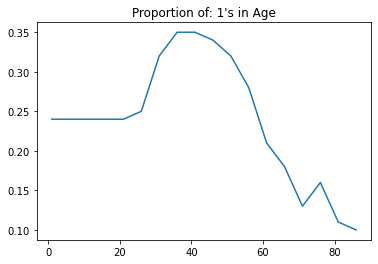

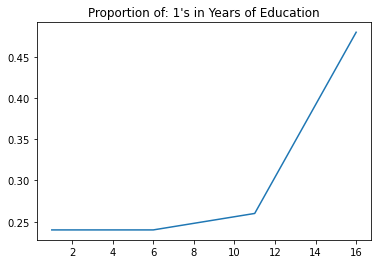

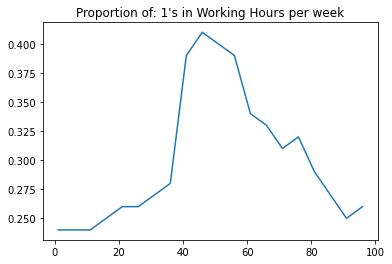

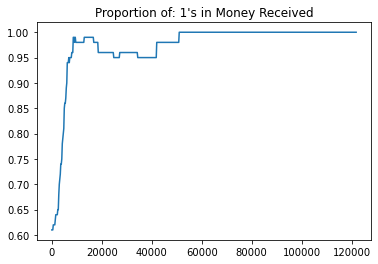

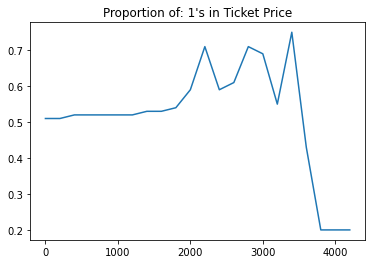

In [22]:
for feature in metric_features:
    plot_breaking_point( df_clean, feature)

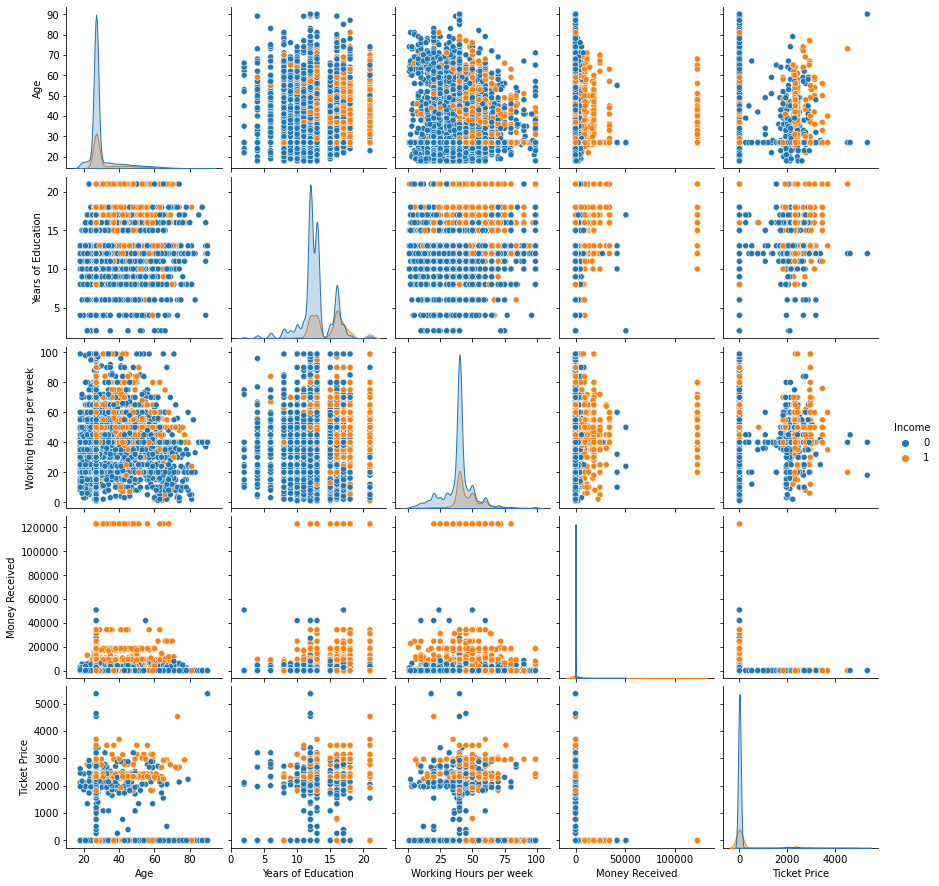

In [23]:
sns.pairplot(df_clean[metric_features + ['Income'] ], hue = 'Income')

By seen the plot above we can notice some high values for Ticket Price (above 4000) and for Money Received (above 60000).

Since those are metric features, scaling would be an important tool to make our models perform better, since, those values, although extreme, are relevant to assess our task.

In the boxplots below you can see that there's not a feasible cutout point to really be sure when we're dealing with an extreme value:

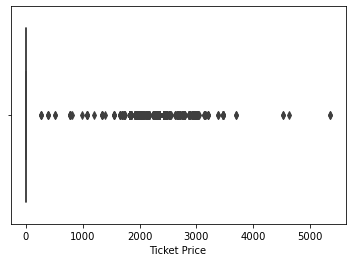

In [24]:
sns.boxplot(x=df_clean['Ticket Price'])

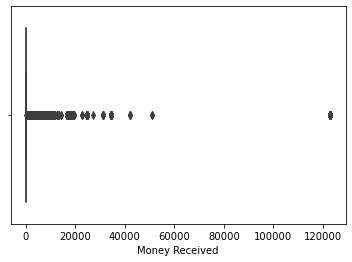

In [25]:
sns.boxplot(x= df_clean['Money Received'])

## Variables Assesment:

We have several categorical features. We could encode each one of the variables with one encoder or we can encode them based on the information above to create new variables.

Let's use the encode our dataset:

In [26]:
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(df_clean[categorical_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=df_clean.index, columns=ohc_feat_names)
ohc_df

,x0_America,x0_Asia,x0_Europe,x0_Oceania,x1_Married,x1_Married - Spouse Missing,x1_Married - Spouse in the Army,x1_Separated,x1_Single,x1_Widow,...,x6_Household Services,x6_IT,x6_Machine Operators & Inspectors,x6_Management,x6_Other services,x6_Professor,x6_Repair & constructions,x6_Sales,x6_Security,x6_Transports
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22173,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22174,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22175,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
22176,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [27]:
df_torun = pd.concat([df_clean, ohc_df], axis=1)
#df_torun = pd.concat([df_clean.drop(columns=categorical_features + ['CITIZEN_ID', 'Name', 'Birthday']), ohc_df], axis=1)

In [30]:
# Double checking NaN values!!!!!!!!!!

df0 = df_torun.copy()
#df0.replace({'?': None}, inplace=True)
df0.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

Let's add some extra features with a binary encoding based on the graphs above and asess all the variables.

Defining a function to help us with the task:

In [403]:
def column_creator_encoded(df, conditions, old_column, new_column_name):
    
    df[ new_column_name ] = df[ old_column ]
    
    df[new_column_name] = df[new_column_name].replace(conditions, regex=True)
    
    return df

Let's define the conditions for encoding:

In [32]:
# Grouping to see if it is married, or not

for c in categorical_features:
    df_torun[c] = df_torun[c].str.lower()

# Grouping with the people that live togeter
repl_lives = {
    'wife': 1,
    'husband': 1,
    'children': 0,
    'other': 0,
    'alone': 0
}

# Grouping for the type of education level
repl_advanced_edulvl = {
    'professional school': 0,
    'bachelors': 0,
    'high school': 0,
    'middle school': 0,
    'primary school': 0,
    'preschool': 0,
    'masters': 1,
    'phd': 1
}

# Grouping for the most predominant work sector
rep_emp_sec_priv = {
    'private': 1,
    'public': 0,
    'self': 0,
    'never': 0,
    'unemployed': 0
}

# Grouping for the type of role (prof and management)
rep_role = {
    'professor': 1,
    'management': 1,
    'sales': 0,
    'security': 0,
    'army': 0,
    'services':0,
    'repair': 0,
    'administratives': 0,
    'machine': 0,
    'transports': 0,
    'cleaners': 0,
    'it': 0,
    'fishing': 0
}

# Grouping for the top 4 roles.
rep_role2 = {
    'professor': 1,
    'management': 1,
    'sales': 1,
    'security': 0,
    'army': 0,
    'services':0,
    'repair': 1,
    'administratives': 0,
    'machine': 0,
    'transports': 0,
    'cleaners': 0,
    'it': 0,
    'fishing': 0
}

# Manually encoding:
column_creator_encoded(df_torun, repl_lives, 'Lives with', 'Lives with' + ' partner')
column_creator_encoded(df_torun, repl_advanced_edulvl, 'Education Level', 'Education Level' + ' advanced')
column_creator_encoded(df_torun, rep_emp_sec_priv, 'Employment Sector', 'Employment Sector' + ' private')
column_creator_encoded(df_torun, rep_role, 'Role', 'Role' + ' (prof+manag)')
column_creator_encoded(df_torun, rep_role2, 'Role', 'Role' + ' (new)')

# Manually replacing the '?' in the columns
#df_torun['Employment Sector private'].replace({'?': 0}, inplace=True) #, 'never worked': 0
#df_torun['Role (prof+manag)'].replace({'?': 0}, inplace=True) # unknown values
#df_torun['Role (new)'].replace({'?': 0}, inplace=True) # unknown values 

,CITIZEN_ID,Name,Birthday,Age,Male,Native Continent,Marital Status,Lives with,Base Area,Education Level,...,x6_Professor,x6_Repair & constructions,x6_Sales,x6_Security,x6_Transports,Lives with partner,Education Level advanced,Employment Sector private,Role (prof+manag),Role (new)
0,12486,Mr. Adam Glover,"July 1,2003",44,1,europe,married,wife,northbury,high school + postgraduation,...,0.0,1.0,0.0,0.0,0.0,1,0,1,0,1
1,12487,Mr. Cameron McDonald,"January 25,2006",27,1,europe,married,wife,northbury,professional school,...,0.0,1.0,0.0,0.0,0.0,1,0,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",27,1,europe,married,wife,northbury,professional school,...,0.0,0.0,1.0,0.0,0.0,1,0,1,0,1
3,12489,Mr. Alexander Gill,"March 25,1985",27,1,europe,married,wife,northbury,high school - 2nd cycle,...,0.0,0.0,0.0,1.0,0.0,1,0,1,0,0
4,12490,Mr. Neil Piper,"May 29,2015",27,1,europe,single,other family,northbury,phd,...,1.0,0.0,0.0,0.0,0.0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22173,34881,Mrs. Lisa Alsop,"March 15,2023",27,0,europe,divorced,children,northbury,professional school,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
22174,34882,Mr. Julian Coleman,"March 7,2025",22,1,europe,single,children,northbury,professional school,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
22175,34883,Miss Amelia Walker,"July 20,2022",27,0,europe,single,other family,northbury,masters,...,1.0,0.0,0.0,0.0,0.0,0,1,0,1,1
22176,34884,Mr. Justin Sutherland,"June 11,2011",27,1,europe,single,other family,northbury,bachelors + postgraduation,...,0.0,1.0,0.0,0.0,0.0,0,0,1,0,1


We don't include the NaN values, denoted by '?', in the assessment of the column values, since the proportion of values with Income = 1 for that will be reduced and will cause our feature to be less relevant.

Now we have the binary features we feel could be relevant to the model. Let's drop the columns with unwanted information for our assesment:

In [33]:
df_torun.drop(columns=categorical_features + ['CITIZEN_ID', 'Name', 'Birthday'], inplace = True)

df_torun.head()

,Age,Male,Years of Education,Working Hours per week,Money Received,Ticket Price,Income,x0_America,x0_Asia,x0_Europe,...,x6_Professor,x6_Repair & constructions,x6_Sales,x6_Security,x6_Transports,Lives with partner,Education Level advanced,Employment Sector private,Role (prof+manag),Role (new)
0,44,1,13,40,0,2273,1,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1,0,1,0,1
1,27,1,12,40,0,0,1,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1,0,0,0,1
2,27,1,12,46,0,2321,1,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1,0,1,0,1
3,27,1,11,37,5395,0,1,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1,0,1,0,0
4,27,1,21,45,0,0,1,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0,1,0,1,1


Having so many binary features let's start assessing each one by using decision trees.

We have two encodings for the role columns, to assess which one is more important, let's test the metrics of the decission trees:

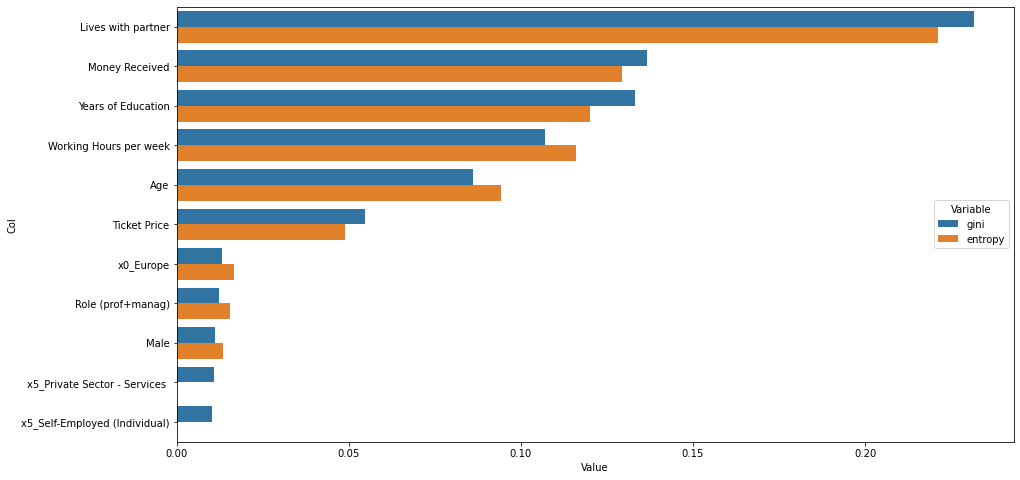

In [37]:
data1 = df_torun.drop(columns = ['Income'])
target1 = df_torun.Income

gini_importance = DecisionTreeClassifier().fit(data1, target1).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(data1, target1).feature_importances_

zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = data1.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)
tidy = tidy[tidy['Value'] > 0.01]

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

Having so many variables, Let's see different intervals for correlations:

In [38]:
method = [ 'pearson', 'kendall', 'spearman' ]

for m in method:
    print('\n--------------------------------- CORRELATION METHOD:', m, '------------------------------------------------')
    # Saving a dataframe with the correlations values:
    dfc = df_torun.corr(method = m)

    corr_values = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

    for corr in corr_values:
        print('\n\n------------------------------- |Corr| >', corr,'---------------------------------------------\n')

        # Looping through the columns:
        for column in dfc.columns:
            correlated = dfc[ (np.abs(dfc[column]) > corr) ].index.to_list()

            # Only print those that aren't correlated with themselves
            if len(correlated) != 1:
                
                if (column == "Income"):
                    
                    # Coloring the output for the Income column
                    print('---')
                    text = column + ' is correlated with: ' + str(correlated)
                    print( colored(text, 'red') )
                    print('---')
                    
                else:
                    print( column, 'is correlated with:', correlated)


--------------------------------- CORRELATION METHOD: pearson ------------------------------------------------


------------------------------- |Corr| > 0.9 ---------------------------------------------

x1_Married is correlated with: ['x1_Married', 'Lives with partner']
x2_Wife is correlated with: ['x2_Wife', 'Lives with partner']
Lives with partner is correlated with: ['x1_Married', 'x2_Wife', 'Lives with partner']


------------------------------- |Corr| > 0.8 ---------------------------------------------

x1_Married is correlated with: ['x1_Married', 'x2_Wife', 'Lives with partner']
x2_Wife is correlated with: ['x1_Married', 'x2_Wife', 'Lives with partner']
x5_Private Sector - Services  is correlated with: ['x5_Private Sector - Services ', 'Employment Sector private']
Lives with partner is correlated with: ['x1_Married', 'x2_Wife', 'Lives with partner']
Employment Sector private is correlated with: ['x5_Private Sector - Services ', 'Employment Sector private']


-----------------

x3_Wigston is correlated with: ['x0_Asia', 'x3_Wigston']
x4_Bachelors + PostGraduation is correlated with: ['Years of Education', 'x4_Bachelors + PostGraduation', 'x4_High School + PostGraduation', 'x4_Professional School', 'Role (prof+manag)', 'Role (new)']
x4_High School + PostGraduation is correlated with: ['x4_Bachelors + PostGraduation', 'x4_High School + PostGraduation', 'x4_Professional School']
x4_High School - 1st Cycle is correlated with: ['Years of Education', 'x4_High School - 1st Cycle']
x4_Masters is correlated with: ['Years of Education', 'x4_Masters', 'x6_Professor', 'Education Level advanced', 'Role (prof+manag)']
x4_Masters + PostGraduation is correlated with: ['Years of Education', 'x4_Masters + PostGraduation', 'x6_Professor', 'Education Level advanced']
x4_Middle School - 1st Cycle is correlated with: ['Years of Education', 'x3_Fanfoss', 'x4_Middle School - 1st Cycle']
x4_Middle School - 2nd Cycle is correlated with: ['Years of Education', 'x4_Middle School - 2nd C



------------------------------- |Corr| > 0.9 ---------------------------------------------

x1_Married is correlated with: ['x1_Married', 'Lives with partner']
x2_Wife is correlated with: ['x2_Wife', 'Lives with partner']
Lives with partner is correlated with: ['x1_Married', 'x2_Wife', 'Lives with partner']


------------------------------- |Corr| > 0.8 ---------------------------------------------

x1_Married is correlated with: ['x1_Married', 'x2_Wife', 'Lives with partner']
x2_Wife is correlated with: ['x1_Married', 'x2_Wife', 'Lives with partner']
x5_Private Sector - Services  is correlated with: ['x5_Private Sector - Services ', 'Employment Sector private']
Lives with partner is correlated with: ['x1_Married', 'x2_Wife', 'Lives with partner']
Employment Sector private is correlated with: ['x5_Private Sector - Services ', 'Employment Sector private']


------------------------------- |Corr| > 0.7 ---------------------------------------------

x1_Married is correlated with: ['x1_M

x6_Sales is correlated with: ['x6_Sales', 'Role (prof+manag)', 'Role (new)']
x6_Security is correlated with: ['x5_Public Sector - Others', 'x6_Security']
x6_Transports is correlated with: ['x6_Transports', 'Role (new)']
Lives with partner is correlated with: ['Male', 'Working Hours per week', 'Income', 'x1_Married', 'x1_Single', 'x2_Children', 'x2_Husband', 'x2_Other Family', 'x2_Wife', 'Lives with partner']
Education Level advanced is correlated with: ['Years of Education', 'Income', 'x4_Masters', 'x4_Masters + PostGraduation', 'x4_PhD', 'x4_Professional School', 'x6_Professor', 'Education Level advanced', 'Role (prof+manag)', 'Role (new)']
Employment Sector private is correlated with: ['x5_Private Sector - Services ', 'x5_Public Sector - Government', 'x5_Public Sector - Others', 'x5_Self-Employed (Company)', 'x5_Self-Employed (Individual)', 'Employment Sector private']
Role (prof+manag) is correlated with: ['Years of Education', 'Income', 'x4_Bachelors + PostGraduation', 'x4_Masters'



------------------------------- |Corr| > 0.9 ---------------------------------------------

x1_Married is correlated with: ['x1_Married', 'Lives with partner']
x2_Wife is correlated with: ['x2_Wife', 'Lives with partner']
Lives with partner is correlated with: ['x1_Married', 'x2_Wife', 'Lives with partner']


------------------------------- |Corr| > 0.8 ---------------------------------------------

x1_Married is correlated with: ['x1_Married', 'x2_Wife', 'Lives with partner']
x2_Wife is correlated with: ['x1_Married', 'x2_Wife', 'Lives with partner']
x5_Private Sector - Services  is correlated with: ['x5_Private Sector - Services ', 'Employment Sector private']
Lives with partner is correlated with: ['x1_Married', 'x2_Wife', 'Lives with partner']
Employment Sector private is correlated with: ['x5_Private Sector - Services ', 'Employment Sector private']


------------------------------- |Corr| > 0.7 ---------------------------------------------

x1_Married is correlated with: ['x1_M

x4_Masters is correlated with: ['Years of Education', 'x4_Masters', 'x6_Professor', 'Education Level advanced', 'Role (prof+manag)']
x4_Masters + PostGraduation is correlated with: ['Years of Education', 'x4_Masters + PostGraduation', 'x6_Professor', 'Education Level advanced']
x4_Middle School - 1st Cycle is correlated with: ['x3_Fanfoss', 'x4_Middle School - 1st Cycle']
x4_Middle School - 2nd Cycle is correlated with: ['Years of Education', 'x4_Middle School - 2nd Cycle']
x4_Middle School Complete is correlated with: ['Years of Education', 'x4_Middle School Complete']
x4_PhD is correlated with: ['Years of Education', 'x4_PhD', 'x6_Professor', 'Education Level advanced']
x4_Professional School is correlated with: ['Years of Education', 'x4_Bachelors + PostGraduation', 'x4_High School + PostGraduation', 'x4_Professional School', 'x6_Professor', 'Education Level advanced', 'Role (prof+manag)']
x5_Private Sector - Others is correlated with: ['x5_Private Sector - Others', 'x5_Private Sect

Some features stand out more than others when compared with the target variable: 

* 'Years of Education', 'x1_Married', 'Lives with partner': are in the 3 types of correlations and have considerable correlation values.

* 'x1_Single', 'x2_Wife', 'Role (prof+manag)', 'Education Level advanced', 'Working Hours per week', 'Money Received', 'x6_Management': are correlated in a less significant level with the target variable.

But for the two groups of variables listed above there's some colinearity. For example:

In [39]:
dfc = df_torun.corr()

dfc.loc['Income'].sort_values(ascending=False)

Income                    1.000000
Lives with partner        0.438443
x1_Married                0.432694
x2_Wife                   0.390043
Years of Education        0.330552
                            ...   
x4_Professional School   -0.131298
x6_Other services        -0.155765
x2_Other Family          -0.187254
x2_Children              -0.221318
x1_Single                -0.309004
Name: Income, Length: 101, dtype: float64

In [40]:
dfc.loc['Lives with partner'].sort_values(ascending=False)

Lives with partner    1.000000
x1_Married            0.983658
x2_Wife               0.907945
Income                0.438443
Male                  0.437530
                        ...   
x1_Widow             -0.164003
x1_Separated         -0.164367
x2_Children          -0.382436
x2_Other Family      -0.540247
x1_Single            -0.631458
Name: Lives with partner, Length: 101, dtype: float64

To make the above output more clear, let's print only the correlation of the features that correlate with our target variable on each interval:

In [41]:
method = [ 'pearson', 'kendall', 'spearman' ]

for m in method:
    print('\n--------------------------------- CORRELATION METHOD:', m, '------------------------------------------------')
    # Saving a dataframe with the correlations values:
    dfc = df_torun.corr(method = m)

    corr_values = [0.4, 0.3, 0.2]

    for corr in corr_values:
        print('\n\n------------------------------- |Corr| >', corr,'---------------------------------------------\n')

        correlated = dfc[ (np.abs(dfc['Income']) > corr) ].index.to_list()

        # Only print those that aren't correlated with themselves
        if len(correlated) != 1:
            
            correlated.remove('Income')
            
            print('---')
            text = 'Income is correlated with: ' + str(correlated)
            print( colored(text, 'red') )
            print('---')

            for elm in correlated:
                correlated = dfc[ (np.abs(dfc[elm]) > corr) ].index.to_list()
                
                print(elm, 'is correlated with: ', correlated, '\n')


--------------------------------- CORRELATION METHOD: pearson ------------------------------------------------


------------------------------- |Corr| > 0.4 ---------------------------------------------

---
Income is correlated with: ['x1_Married', 'Lives with partner']
---
x1_Married is correlated with:  ['Male', 'Income', 'x1_Married', 'x1_Single', 'x2_Other Family', 'x2_Wife', 'Lives with partner'] 

Lives with partner is correlated with:  ['Male', 'Income', 'x1_Married', 'x1_Single', 'x2_Other Family', 'x2_Wife', 'Lives with partner'] 



------------------------------- |Corr| > 0.3 ---------------------------------------------

---
Income is correlated with: ['Years of Education', 'x1_Married', 'x1_Single', 'x2_Wife', 'Lives with partner', 'Role (prof+manag)']
---
Years of Education is correlated with:  ['Years of Education', 'Income', 'x4_Bachelors + PostGraduation', 'x4_Masters', 'x4_PhD', 'x4_Professional School', 'x6_Professor', 'Education Level advanced', 'Role (prof+manag



------------------------------- |Corr| > 0.4 ---------------------------------------------

---
Income is correlated with: ['x1_Married', 'Lives with partner']
---
x1_Married is correlated with:  ['Male', 'Income', 'x1_Married', 'x1_Single', 'x2_Other Family', 'x2_Wife', 'Lives with partner'] 

Lives with partner is correlated with:  ['Male', 'Income', 'x1_Married', 'x1_Single', 'x2_Other Family', 'x2_Wife', 'Lives with partner'] 



------------------------------- |Corr| > 0.3 ---------------------------------------------

---
Income is correlated with: ['Years of Education', 'x1_Married', 'x1_Single', 'x2_Wife', 'Lives with partner', 'Role (prof+manag)']
---
Years of Education is correlated with:  ['Years of Education', 'Income', 'x4_Bachelors + PostGraduation', 'x4_Masters', 'x4_Professional School', 'x6_Professor', 'Education Level advanced', 'Role (prof+manag)', 'Role (new)'] 

x1_Married is correlated with:  ['Male', 'Income', 'x1_Married', 'x1_Single', 'x2_Children', 'x2_Other

Therefore, by taking the important features highlighted, and doing a correlation analysis we consider as significant variables: 'Years of Education', 'Lives with partner', 'Working Hours per week', 'Money Received', 'Role (prof+manag)'.

Checking for colinearity again:

In [42]:
df_torun[[
    'Years of Education', 
    'Lives with partner', 
    'Working Hours per week', 
    'Money Received', 
    'Role (prof+manag)',
    'Education Level advanced',
    'Income']].corr(method = 'pearson')

,Years of Education,Lives with partner,Working Hours per week,Money Received,Role (prof+manag),Education Level advanced,Income
Years of Education,1.000000,0.081006,0.129470,0.122438,0.480579,0.560542,0.330552
Lives with partner,0.081006,1.000000,0.197277,0.085605,0.108702,0.101544,0.438443
Working Hours per week,0.129470,0.197277,1.000000,0.074579,0.148782,0.107230,0.215484
Money Received,0.122438,0.085605,0.074579,1.000000,0.109446,0.136049,0.221041
Role (prof+manag),0.480579,0.108702,0.148782,0.109446,1.000000,0.396354,0.305951
Education Level advanced,0.560542,0.101544,0.107230,0.136049,0.396354,1.000000,0.264620
Income,0.330552,0.438443,0.215484,0.221041,0.305951,0.264620,1.000000


In [43]:
df_torun[[
    'Years of Education', 
    'Lives with partner', 
    'Working Hours per week', 
    'Money Received', 
    'Role (prof+manag)',
    'Education Level advanced',
    'Income']].corr(method = 'spearman')

,Years of Education,Lives with partner,Working Hours per week,Money Received,Role (prof+manag),Education Level advanced,Income
Years of Education,1.000000,0.070939,0.147343,0.111299,0.479444,0.497903,0.319566
Lives with partner,0.070939,1.000000,0.227977,0.127859,0.108702,0.101544,0.438443
Working Hours per week,0.147343,0.227977,1.000000,0.091951,0.181166,0.117754,0.254520
Money Received,0.111299,0.127859,0.091951,1.000000,0.107788,0.102813,0.274775
Role (prof+manag),0.479444,0.108702,0.181166,0.107788,1.000000,0.396354,0.305951
Education Level advanced,0.497903,0.101544,0.117754,0.102813,0.396354,1.000000,0.264620
Income,0.319566,0.438443,0.254520,0.274775,0.305951,0.264620,1.000000


In [44]:
df_torun[[
    'Years of Education', 
    'Lives with partner', 
    'Working Hours per week', 
    'Money Received', 
    'Role (prof+manag)',
    'Education Level advanced',
    'Income']].corr(method = 'kendall')

,Years of Education,Lives with partner,Working Hours per week,Money Received,Role (prof+manag),Education Level advanced,Income
Years of Education,1.000000,0.063490,0.117531,0.097917,0.429103,0.445624,0.286012
Lives with partner,0.063490,1.000000,0.202135,0.125362,0.108702,0.101544,0.438443
Working Hours per week,0.117531,0.202135,1.000000,0.080122,0.160630,0.104406,0.225669
Money Received,0.097917,0.125362,0.080122,1.000000,0.105684,0.100806,0.269409
Role (prof+manag),0.429103,0.108702,0.160630,0.105684,1.000000,0.396354,0.305951
Education Level advanced,0.445624,0.101544,0.104406,0.100806,0.396354,1.000000,0.264620
Income,0.286012,0.438443,0.225669,0.269409,0.305951,0.264620,1.000000


There's colinearity between Years of Education and Role (prof+manag), Years of Education seems more significant since it has bigger correlation than Role (prof+manag) for 2/3 of the models.

Education Level advanced has considerable colinearity with the Years of Education and Role (prof+manag). We will not consider it moving forward.

In [45]:
def Highlight(val):
    """
    Function to define colors for a dataframe
    """
    if np.abs(val) <= 0.05:
        color = 'red'
    else:
        color = 'green'
    return 'background-color: %s' % color

Let's do a ridge regression model and see the coeficient for each variable:

In [46]:
data1 = df_torun.drop(['Income'], axis=1)
target1 = pd.DataFrame(df_torun['Income'], columns = ['Income'])

# Creating the Ridge object
ridge1 = RidgeCV()

# Fitting it to our data:
ridge1.fit(X = data1, y = target1)

coef_ridge = pd.DataFrame(ridge1.coef_.T, 
                          index = data1.columns, 
                          columns=['Coef'])\
                          .sort_values(by = 'Coef', ascending=False)

coef_ridge.style.applymap(Highlight, subset=['Coef'] )

,Coef
Lives with partner,0.170782
x2_Husband,0.144237
Education Level advanced,0.136515
x3_Eelry,0.116016
x1_Married - Spouse in the Army,0.114243
x3_Alverton,0.096036
x5_Public Sector - Government,0.091529
x3_Kald,0.083539
x6_IT,0.077073
x4_PhD,0.076212


#### Assessing our new variables:

* **Lives with partner:** is flagged by most assessment methods as fundamental.

* **Years of education, Role (prof+manag):** have a high colinearity and for some assessment methods ones have more importance. We'll keep both and test, one at the time, which one performs better.

* **Working Hours per week, Money Received:** mostly important for decision trees, and with modest correlations. For Money Received there's some extreme values as we saw above.

* **Age, Ticket Price:** mostly relevant for decision trees (and age already filtered for people above 18 years old)

In [47]:
df_torun[['Lives with partner', 
          'Years of Education', 
          'Role (prof+manag)',
          'Working Hours per week',
          'Money Received',
          'Ticket Price',
          'Age',
          'Income'
        ]].to_csv('first_assesment.csv',index=False)

# Models Assessments

Let's import out dataset:

In [3]:
df1 = pd.read_csv('first_assesment.csv')

df1.head()

,Lives with partner,Years of Education,Role (prof+manag),Working Hours per week,Money Received,Ticket Price,Age,Income
0,1,13,0,40,0,2273,44,1
1,1,12,0,40,0,0,27,1
2,1,12,0,46,0,2321,27,1
3,1,11,0,37,5395,0,27,1
4,0,21,1,45,0,0,27,1


Splitting the data:

In [4]:
XX = df1.drop(columns=['Income'])

YY = df1['Income']

X_train, X_test, y_train, y_test = train_test_split(XX, 
                                                  YY, 
                                                  test_size = 0.30, 
                                                  stratify = YY,
                                                  random_state=5)

In the following step we're going to be doing an exploratory performance testing for a Naive Bayes model with our splitted data taking into consideration different columns:

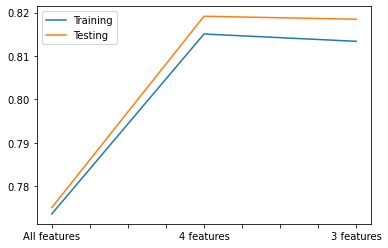

In [5]:
""" HAVING ALL THE FEATURES """
modelNB = GaussianNB()

modelNB.fit(X = X_train, y = y_train)

# Predicting the values for our training set on according to the model
labels_train = modelNB.predict(X_train)

# Predicting the values for our test set according to the model
labels_test = modelNB.predict(X_test)

df_bayesF1 = pd.DataFrame(columns = ['Training', 'Testing'])

# Apending the F1 result:
df_bayesF1.loc['All features'] = [f1_score(y_train, labels_train, average = 'weighted') , 
                                  f1_score(y_test, labels_test, average = 'weighted') ]

""" HAVING 4 FEATURES """

X_train_4 = X_train[['Years of Education','Working Hours per week', 'Lives with partner', 'Role (prof+manag)']]
X_test_4 = X_test[['Years of Education','Working Hours per week', 'Lives with partner', 'Role (prof+manag)']]

modelNB.fit(X = X_train_4, y = y_train)
labels_train = modelNB.predict(X_train_4)
labels_test = modelNB.predict(X_test_4)

df_bayesF1.loc['4 features'] = [f1_score(y_train, labels_train, average = 'weighted'), 
                                f1_score(y_test, labels_test, average = 'weighted') ]

""" HAVING 3 FEATURES """

X_train_3 = X_train[['Years of Education','Lives with partner', 'Role (prof+manag)']]
X_test_3 = X_test[['Years of Education','Lives with partner', 'Role (prof+manag)']]

modelNB.fit(X = X_train_3, y = y_train)
labels_train = modelNB.predict(X_train_3)
labels_test = modelNB.predict(X_test_3)

df_bayesF1.loc['3 features'] = [f1_score(y_train, labels_train, average = 'weighted'), 
                                f1_score(y_test, labels_test, average = 'weighted') ]

df_bayesF1.plot()

Looking at the results above, providing to our model more columns it will not cause overfitting but a noticeable decrement of it's performance, also reducing the number of features too much can cause the model to overfit. 

Considering that scaling our data is an important step to have better results for some models, we will create now some functions to help us with this assessment. 

For the assessment, we will justify our decision making by using the results on the past section (Variables Assessment), therefore, we are looking to provide to each model the features that are needeed the most for them to perform better.

##### ======================================================
#### Functions

In [6]:
def scaling(X_train, X_test):
    """
    Scaler of variables using the training set 
    """
    minmax = MinMaxScaler().fit(X_train)
    standard = StandardScaler().fit(X_train)
    robust = RobustScaler().fit(X_train)
    
    return minmax.transform(X_train) , minmax.transform(X_test),\
            standard.transform(X_train) , standard.transform(X_test),\
            robust.transform(X_train) , robust.transform(X_test)

In [7]:
def appending_lines(df, list_ , INDEX):
    """
    This function will append lines to the below function with the scores.
    """
    df.loc[INDEX] = list_

In [8]:
def IndividualModel_Scoring(X_train, y_train, X_test, y_test, model, model_name, all_scalers = True):
    """
    Scoring the training and validation sets.
    
    First 4 parameters are the sets splitted, 
    ML model object, 
    Model name for the output df, this will allow us to identify the results in a final dataframe, 
    Default = True, since you want to run the model for all scalers. (For decision trees, for example, scaling can be omitted.)
    """
    # Defining output dataset:
    df_out = pd.DataFrame(columns = ['Model', 'Scale Type', 'Training', 'Testing'])
    
    if (all_scalers):
        # Calling our scaler function
        minMax_X_train, minMax_X_test, St_X_train, St_X_test, Rob_X_train, Rob_X_test = scaling(X_train, X_test)
        
        # Fitting for training sets, predicting outputs according to those models
        minmax_Fit = model.fit(minMax_X_train, y_train)
        minMax_y_train = minmax_Fit.predict(minMax_X_train)
        minMax_y_test = minmax_Fit.predict(minMax_X_test) 

        # Fitting for training sets, predicting outputs according to those models
        St_Fit = model.fit(St_X_train, y_train)
        St_y_train = St_Fit.predict(St_X_train)
        St_y_test = St_Fit.predict(St_X_test)

        # Fitting for training sets, predicting outputs according to those models
        Rob_Fit = model.fit(Rob_X_train, y_train)
        Rob_y_train = Rob_Fit.predict(Rob_X_train)
        Rob_y_test = Rob_Fit.predict(Rob_X_test)

        # Calculating F1 weighted scores:

        line = [ model_name, 
                  'minmax', 
                  f1_score(y_train, minMax_y_train, average = 'weighted'), 
                  f1_score(y_test, minMax_y_test, average = 'weighted')]

        appending_lines(df_out, line, 0)

        line = [ model_name, 
                  'standard', 
                  f1_score(y_train, St_y_train, average = 'weighted'), 
                  f1_score(y_test, St_y_test, average = 'weighted')]

        appending_lines(df_out, line, 1)

        line = [ model_name, 
                  'robust', 
                  f1_score(y_train, Rob_y_train, average = 'weighted'), 
                  f1_score(y_test, Rob_y_test, average = 'weighted')]

        appending_lines(df_out, line, 2)
    
    else:
        
        # Fitting model and data
        model_Fit = model.fit(X_train, y_train)
        pred_y_train = model_Fit.predict(X_train)
        pred_y_test = model_Fit.predict(X_test)
        
        # Appending the results
        line = [ model_name, 
                  'no_scale', 
                  f1_score(y_train, pred_y_train, average = 'weighted'), 
                  f1_score(y_test, pred_y_test, average = 'weighted')]

        appending_lines(df_out, line, 0)

    return df_out

In [9]:
def model_scores(model_validation_method, X, y, model, scaler = False):
    """
    Once we choose our model we will use a validation method to check for discrepancies.
    Scaler variable is to use when scaling is needed on the model
    """
    
    seconds = []
    score_train = []
    score_test = []
    
    # Loop for partition
    for train_index, test_index in model_validation_method.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Start time
        begin = time.perf_counter()
        
        # We need to scale partitioned data with the provided scaler 
        if (scaler != False):
            scaler_fit = scaler.fit(X_train)
            X_train = scaler_fit.transform(X_train)
            X_test = scaler_fit.transform(X_test)
        
        # Fitting model
        model = model.fit(X_train, y_train)
        
        # Predicting
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # End time
        end = time.perf_counter()
        
        seconds.append(end-begin)
        score_train.append(f1_score(y_train, y_pred_train, average = 'weighted'))
        score_test.append(f1_score(y_test, y_pred_test, average = 'weighted'))
    
    df = pd.DataFrame()
    
    df['Time'] = seconds
    df['Training'] = score_train
    df['Test'] = score_test

    return df

In [10]:
def dataframe_mean_std(df):
    """
    Get the mean and sdv for the rows in a df.
    """
    
    # Calculating mean and stdv for the columns.
    df = df.agg({'mean', 'std'},axis = 0)
    
    # Transforming all columns in str values for grouping below
    
    for col in df.columns:
        df[col] = np.round(df[col],3)
        df[col] = df[col].apply(str)
    
    # Helper dataframe:
    dfout = df.copy()
    
    # Grouping rows:
    for c in df.columns:
        dfout[c] = df[c].loc['mean'] + ' +/- ' + df[c].loc['std'] 
    
    # Dropping the row 1 since it will be duplicated
    dfout.drop(['mean'], inplace = True)
    
    # Resetting index
    dfout.reset_index(drop = True, inplace = True)
    
    return dfout

Moving forward we will assess the performance of different models, and we will need to keep a record of each one of those output locally, to see which parameters work better in each ML model, and globally to see which model has a better result.

Let us then, define a dataset for the global results to keep things organized: 

In [11]:
df_results = pd.DataFrame(columns = ['Model', 'Scale Type', 'Training', 'Testing'])

### Naive Bayes: 

In this subsection we will assess the performance of a Bayes model. We already did some exploring above, but we're missing the scaling of the data, but, in the case of bayes, by definition, scaling does not changes the performance of the model. As you see below:

In [12]:
modelNB = GaussianNB()

IndividualModel_Scoring(X_train, y_train, X_test, y_test, modelNB, 'Bayes_All_Features' )

,Model,Scale Type,Training,Testing
0,Bayes_All_Features,minmax,0.781951,0.785330
1,Bayes_All_Features,standard,0.781951,0.785330
2,Bayes_All_Features,robust,0.769849,0.773127


Then, the assessment done above, as "exploratory", was showing us a guidepath for this model and the important variables to consider. Therefore:

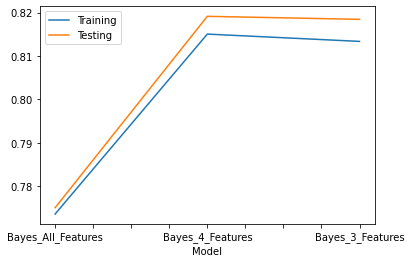

In [13]:
modelNB = GaussianNB()

X_train_4 = X_train[['Years of Education','Working Hours per week', 'Lives with partner', 'Role (prof+manag)']]
X_test_4 = X_test[['Years of Education','Working Hours per week', 'Lives with partner', 'Role (prof+manag)']]

X_train_3 = X_train[['Years of Education','Lives with partner', 'Role (prof+manag)']]
X_test_3 = X_test[['Years of Education','Lives with partner', 'Role (prof+manag)']]

df_bayes = IndividualModel_Scoring(X_train, y_train, X_test, y_test, modelNB, 'Bayes_All_Features' , False) 
df_bayes = df_bayes.append( IndividualModel_Scoring(X_train_4, y_train, X_test_4, y_test, modelNB, 'Bayes_4_Features' , False) ,
                            ignore_index = True )
df_bayes = df_bayes.append( IndividualModel_Scoring(X_train_3, y_train, X_test_3, y_test, modelNB, 'Bayes_3_Features' , False) ,
                            ignore_index = True )

df_bayes\
        .set_index(df_bayes.Model)\
        .plot()

# Bar plot is not that visual on this. Better to stay with the line plot
#df_bayes\
        #.set_index(df_bayes.Model)\
        #.plot.bar()

In [14]:
df_bayes

,Model,Scale Type,Training,Testing
0,Bayes_All_Features,no_scale,0.773625,0.775080
1,Bayes_4_Features,no_scale,0.815064,0.819154
2,Bayes_3_Features,no_scale,0.813381,0.818464


Then, we are going to stay with the results of the Bayes model with 4 features _(['Years of Education','Working Hours per week', 'Lives with partner', 'Role (prof+manag)'])_ for our Kfolds testing:

In [15]:
df_bayes_score = model_scores( KFold(n_splits=50), 
                               XX[['Years of Education','Working Hours per week', 'Lives with partner', 'Role (prof+manag)']], 
                               YY, 
                               modelNB )

dataframe_mean_std(df_bayes_score)

,Time,Training,Test
0,0.014 +/- 0.003,0.816 +/- 0.0,0.816 +/- 0.018


Then, let's append the results of this model to the results dataframe to compare it with the following models.

In [16]:
df_results.loc[0] = df_bayes.loc[1]

df_results

,Model,Scale Type,Training,Testing
0,Bayes_4_Features,no_scale,0.815064,0.819154


### Logistic Regression

Let's start by testing the logistic regression on the data without scaling.

C:\Users\maike\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\maike\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Text(0.5, 1.0, 'All features using LR')

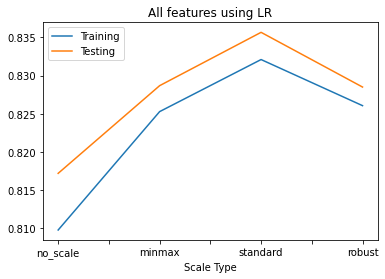

In [31]:
LRmodel = LogisticRegression()

# All columns without scaling:
df_LR = IndividualModel_Scoring(X_train, y_train, X_test, y_test, LRmodel, 'LR_All_Features' , False)

# With scaling:
df_LR = df_LR.append( IndividualModel_Scoring(X_train, y_train, X_test, y_test, LRmodel, 'LR_All_Features') )

df_LR.set_index('Scale Type').plot()
plt.title('All features using LR')

The best F1 for the logistic regression is when we scale using the standard scaler.

Let's start by removing some features from the model:

Text(0.5, 1.0, 'LR performance')

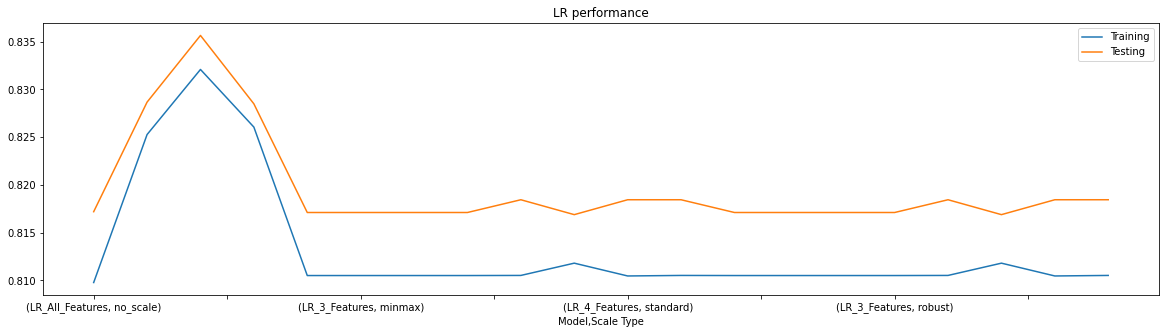

In [33]:
X_train_4 = X_train[['Years of Education','Working Hours per week', 'Lives with partner', 'Role (prof+manag)']]
X_test_4 = X_test[['Years of Education','Working Hours per week', 'Lives with partner', 'Role (prof+manag)']]

X_train_3 = X_train[['Years of Education','Lives with partner', 'Role (prof+manag)']]
X_test_3 = X_test[['Years of Education','Lives with partner', 'Role (prof+manag)']]

# 3: No scaling
df_LR = df_LR.append( IndividualModel_Scoring(X_train_3, y_train, X_test_3, y_test, LRmodel, 'LR_3_Features' , False) )
# With scaling:
df_LR = df_LR.append( IndividualModel_Scoring(X_train_3, y_train, X_test_3, y_test, LRmodel, 'LR_3_Features') )

# 4: No scaling
df_LR = df_LR.append( IndividualModel_Scoring(X_train_4, y_train, X_test_4, y_test, LRmodel, 'LR_4_Features' , False) )
# With scaling:
df_LR = df_LR.append( IndividualModel_Scoring(X_train_4, y_train, X_test_4, y_test, LRmodel, 'LR_4_Features') )

df_LR.set_index(['Model','Scale Type']).plot( figsize=(20, 5) )
plt.title('LR performance')

By looking at the graph above the best performance with the logistic regression is when using all the features and scaling with the standard scaler.

Let's test some more parameters on the logistic regression to see if we can get a better performance

In [35]:
LRmodel_newton = LogisticRegression(solver = 'newton-cg', max_iter = 300)
LRmodel_lib = LogisticRegression(solver = 'liblinear', max_iter = 300)
LRmodel_sag = LogisticRegression(solver = 'sag', max_iter = 300)
LRmodel_saga = LogisticRegression(solver = 'saga', max_iter = 300)

LR_to_test = [LRmodel_newton, LRmodel_lib, LRmodel_sag, LRmodel_saga]

str_for_df = ['LRmodel_newton', 'LRmodel_lib', 'LRmodel_lib', 'LRmodel_sag', 'LRmodel_saga' ]


for LR, text in zip( LR_to_test, str_for_df ):
    
    df_LR = df_LR.append( IndividualModel_Scoring( X_train, y_train, 
                                                   X_test, y_test, 
                                                   LR, text, False) )
    # With scaling:
    df_LR = df_LR.append( IndividualModel_Scoring(X_train, y_train, 
                                                  X_test, y_test, 
                                                  LR, text) )

C:\Users\maike\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\maike\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\maike\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\maike\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Text(0.5, 1.0, 'LR performance')

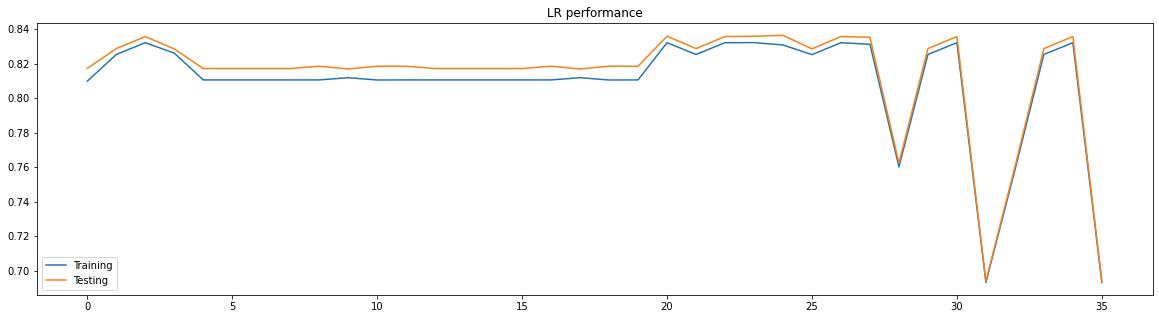

In [41]:
df_LR.reset_index(drop=True, inplace = True)
df_LR.plot( figsize=(20, 5) )
plt.title('LR performance')

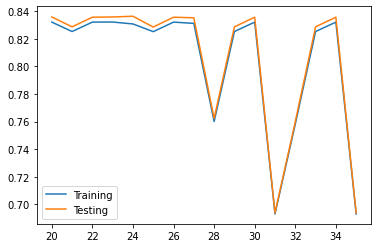

In [47]:
df_LR.loc[20:35].plot()

Some important values:

In [52]:
# Max on the testing
df_LR.loc[24]

Model         LRmodel_lib
Scale Type       no_scale
Training         0.830769
Testing          0.836353
Name: 24, dtype: object

In [51]:
df_LR.loc[27]

Model         LRmodel_lib
Scale Type         robust
Training         0.831184
Testing          0.835232
Name: 27, dtype: object

In [50]:
df_LR.loc[30]

Model         LRmodel_lib
Scale Type       standard
Training         0.832096
Testing          0.835658
Name: 30, dtype: object

In [49]:
df_LR.loc[34]

Model         LRmodel_sag
Scale Type       standard
Training         0.832096
Testing          0.835658
Name: 34, dtype: object

Let's asses each, by using the kFolds method:

In [53]:
# 24
df_LR_score = model_scores( KFold(n_splits=50), 
                            XX, 
                            YY, 
                            LRmodel_lib, 
                            StandardScaler() )

dataframe_mean_std(df_LR_score)

,Time,Training,Test
0,0.162 +/- 0.025,0.833 +/- 0.001,0.832 +/- 0.018


In [55]:
# 27
df_LR_score = model_scores( KFold(n_splits=50), 
                            XX, 
                            YY, 
                            LRmodel_lib, 
                            RobustScaler() )

dataframe_mean_std(df_LR_score)

,Time,Training,Test
0,0.144 +/- 0.018,0.833 +/- 0.001,0.833 +/- 0.018


In [54]:
# 30
df_LR_score = model_scores( KFold(n_splits=50), 
                            XX, 
                            YY, 
                            LRmodel_lib, 
                            StandardScaler() )

dataframe_mean_std(df_LR_score)

,Time,Training,Test
0,0.07 +/- 0.014,0.834 +/- 0.001,0.834 +/- 0.018


In [56]:
# 34
df_LR_score = model_scores( KFold(n_splits=50), 
                            XX, 
                            YY, 
                            LRmodel_sag, 
                            StandardScaler() )

dataframe_mean_std(df_LR_score)

,Time,Training,Test
0,0.12 +/- 0.018,0.834 +/- 0.001,0.834 +/- 0.018


The performance for 30 and 34 is the same but 34 takes more time to train and has a solver that is dependant on the scaling of the data, the solver liblineal is more suited for small datasets and is the one we're going to choose

In [57]:
df_results.loc[1] = df_LR.loc[30]

df_results

,Model,Scale Type,Training,Testing
0,Bayes_4_Features,no_scale,0.815064,0.819154
1,LRmodel_lib,standard,0.832096,0.835658


## Decision trees:

This ML algorithm does not need scaling to perform. We're going to assess in this section the performance of it with different parameters to try to find the one that suits better our problem.

Depth: 32 Node count: 3299 Leaves: 1650
Depth: 8 Node count: 97 Leaves: 49
Depth: 19 Node count: 1445 Leaves: 723


Text(0.5, 1.0, 'Decision Trees performance')

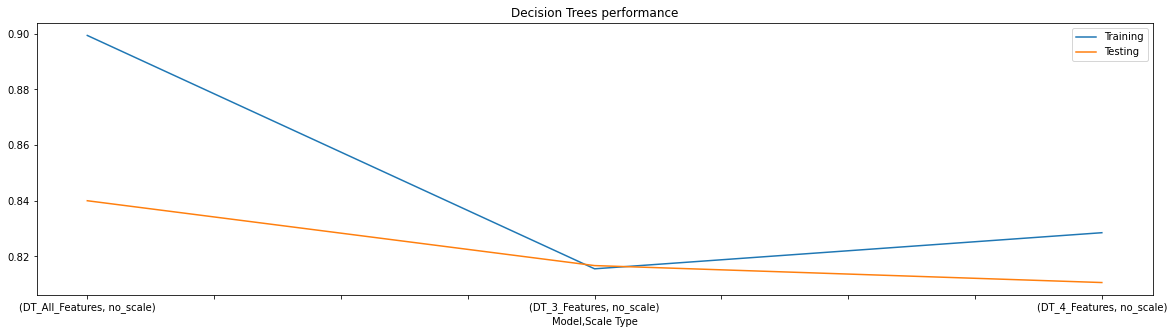

In [58]:
dt_basic = DecisionTreeClassifier()

# Using all the columns in the data
df_DT = IndividualModel_Scoring(X_train, y_train, 
                                X_test, y_test, 
                                dt_basic, 'DT_All_Features' , False)

print('Depth:', dt_basic.get_depth(), 
      'Node count:', dt_basic.tree_.node_count, 
      'Leaves:', dt_basic.get_n_leaves())

# 3: No scaling
df_DT = df_DT.append( IndividualModel_Scoring(X_train_3, y_train, 
                                              X_test_3, y_test, 
                                              dt_basic, 'DT_3_Features', False ) )

print('Depth:', dt_basic.get_depth(), 
      'Node count:', dt_basic.tree_.node_count, 
      'Leaves:', dt_basic.get_n_leaves())

# 4: No scaling
df_DT = df_DT.append( IndividualModel_Scoring(X_train_4, y_train, 
                                              X_test_4, y_test, 
                                              dt_basic, 'DT_4_Features' , False) )

print('Depth:', dt_basic.get_depth(), 
      'Node count:', dt_basic.tree_.node_count, 
      'Leaves:', dt_basic.get_n_leaves())

df_DT.set_index(['Model','Scale Type']).plot( figsize=(20, 5) )
plt.title('Decision Trees performance')

For the models with less variables we have a good performance, even when compared with the previous models tested, but we have the best performance when we do not remove any of the selected features from the dataset but we have overfitting in that case.

Let's try to reduce the overfitting by testing some parameters in the decision trees.

In [59]:
dt_random = DecisionTreeClassifier(splitter = 'random')
# Metrics
dt_entropy = DecisionTreeClassifier(criterion = 'entropy')
dt_gini = DecisionTreeClassifier(criterion = 'gini')
# Depth
dt_depth23 = DecisionTreeClassifier(max_depth = 23)
dt_depth27 = DecisionTreeClassifier(max_depth = 27)
dt_depth30 = DecisionTreeClassifier(max_depth = 30)
# Samples split
dt_min10 = DecisionTreeClassifier(min_samples_split = 10)
dt_min100 = DecisionTreeClassifier(min_samples_split = 100)
dt_min200 = DecisionTreeClassifier(min_samples_split = 200)
dt_min500 = DecisionTreeClassifier(min_samples_split = 500)
# Min Samples
dt_min_sam50 = DecisionTreeClassifier(min_samples_leaf = 50)
dt_min_sam100 = DecisionTreeClassifier(min_samples_leaf = 100)
dt_min_sam200 = DecisionTreeClassifier(min_samples_leaf = 200)
# Best split using weight
dt_min_weight09 = DecisionTreeClassifier(min_weight_fraction_leaf = 0.09)
dt_min_weight15 = DecisionTreeClassifier(min_weight_fraction_leaf = 0.15)
dt_min_weight2 = DecisionTreeClassifier(min_weight_fraction_leaf = 0.2)
# Impurity
dt_impurity02 = DecisionTreeClassifier(min_impurity_decrease=0.02)
dt_impurity1 = DecisionTreeClassifier(min_impurity_decrease=0.1)

In [60]:
DT_to_test = [dt_random, 
              dt_entropy, dt_gini, 
              dt_depth23, dt_depth27, dt_depth30,
              dt_min10, dt_min100, dt_min200, dt_min500, 
              dt_min_sam50, dt_min_sam100, dt_min_sam200, 
              dt_min_weight09, dt_min_weight15, dt_min_weight2, 
              dt_impurity02, dt_impurity1]

str_for_df = ['dt_random',
              'dt_entropy', 'dt_gini', 
              'dt_depth23', 'dt_depth27', 'dt_depth30',
              'dt_min10', 'dt_min100', 'dt_min200', 'dt_min500',
              'dt_min_sam50', 'dt_min_sam100', 'dt_min_sam200',
              'dt_min_weight09','dt_min_weight15', 'dt_min_weight2',
              'dt_impurity02', 'dt_impurity1' ]

for DT, text in zip( DT_to_test, str_for_df ):
    df_DT = df_DT.append( IndividualModel_Scoring( X_train, y_train, 
                                                   X_test, y_test, 
                                                   DT, text, False) )

Text(0.5, 1.0, 'Decision Trees performance')

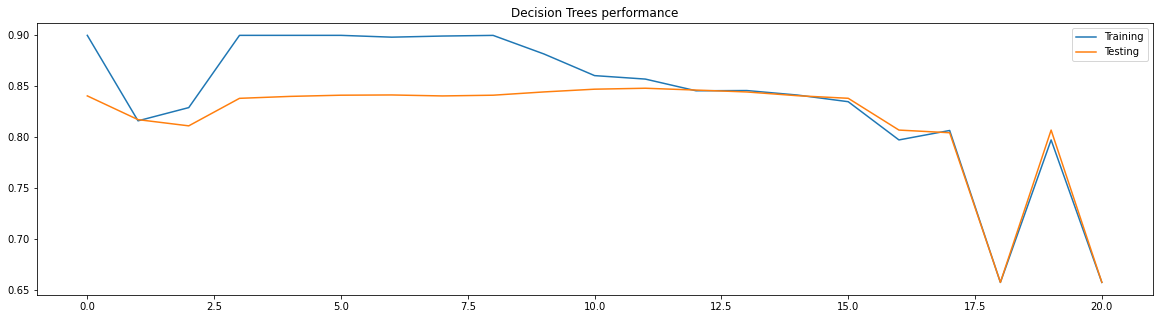

In [61]:
df_DT.reset_index(drop = True, inplace = True)
df_DT.plot( figsize=(20, 5) )
plt.title('Decision Trees performance')

By checking the graph above, the models from the index 9 to 15 have a good performance, with a balanced overfitting. 

In [62]:
df_DT.loc[9:15]

,Model,Scale Type,Training,Testing
9,dt_min10,no_scale,0.881158,0.843889
10,dt_min100,no_scale,0.859892,0.846579
11,dt_min200,no_scale,0.856499,0.847510
12,dt_min500,no_scale,0.845025,0.845723
13,dt_min_sam50,no_scale,0.845249,0.843864
14,dt_min_sam100,no_scale,0.840829,0.840180
15,dt_min_sam200,no_scale,0.834311,0.837652


In [63]:
dt_mix1 = DecisionTreeClassifier(min_samples_leaf = 200, min_samples_split = 100) # giny by default
dt_mix2 = DecisionTreeClassifier(min_samples_leaf = 200, min_samples_split = 100, criterion = 'entropy')
dt_mix3 = DecisionTreeClassifier(min_samples_leaf = 200, min_samples_split = 50) 
dt_mix4 = DecisionTreeClassifier(min_samples_leaf = 200, min_samples_split = 50, criterion = 'entropy')

dt_mix5 = DecisionTreeClassifier(min_samples_leaf = 100, min_samples_split = 100)
dt_mix6 = DecisionTreeClassifier(min_samples_leaf = 100, min_samples_split = 100, criterion = 'entropy')
dt_mix7 = DecisionTreeClassifier(min_samples_leaf = 100, min_samples_split = 50)
dt_mix8 = DecisionTreeClassifier(min_samples_leaf = 100, min_samples_split = 50, criterion = 'entropy')

dt_mix9 = DecisionTreeClassifier(min_samples_leaf = 10, min_samples_split = 50)
dt_mix10 = DecisionTreeClassifier(min_samples_leaf = 10, min_samples_split = 50, criterion = 'entropy')
dt_mix11 = DecisionTreeClassifier(min_samples_leaf = 10, min_samples_split = 50)
dt_mix12 = DecisionTreeClassifier(min_samples_leaf = 10, min_samples_split = 50, criterion = 'entropy')

dt_mix13 = DecisionTreeClassifier(min_samples_leaf = 10, min_samples_split = 100)
dt_mix14 = DecisionTreeClassifier(min_samples_leaf = 10, min_samples_split = 100, criterion = 'entropy')


DT_to_test = [dt_mix1, dt_mix2, dt_mix3, dt_mix4, dt_mix5, dt_mix6, dt_mix7, dt_mix8, dt_mix9, dt_mix10,
              dt_mix11, dt_mix12, dt_mix13, dt_mix14]

str_for_df = ['dt_mix' + str(i) for i in range(1,15)]

for DT, text in zip( DT_to_test, str_for_df ):
    df_DT = df_DT.append( IndividualModel_Scoring( X_train, y_train, 
                                                   X_test, y_test, 
                                                   DT, text, False) )

Text(0.5, 1.0, 'Decision Trees performance')

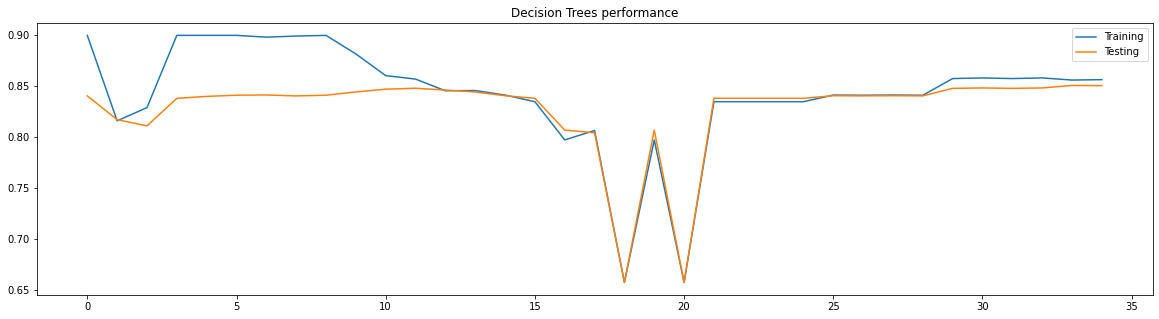

In [64]:
df_DT.reset_index(drop = True, inplace = True)
df_DT.plot( figsize=(20, 5) )
plt.title('Decision Trees performance')

In [65]:
df_DT.loc[12:13]

,Model,Scale Type,Training,Testing
12,dt_min500,no_scale,0.845025,0.845723
13,dt_min_sam50,no_scale,0.845249,0.843864


In [66]:
df_DT.loc[21::]

,Model,Scale Type,Training,Testing
21,dt_mix1,no_scale,0.834311,0.837652
22,dt_mix2,no_scale,0.834311,0.837652
23,dt_mix3,no_scale,0.834311,0.837652
24,dt_mix4,no_scale,0.834311,0.837652
25,dt_mix5,no_scale,0.840829,0.840180
26,dt_mix6,no_scale,0.840644,0.840020
27,dt_mix7,no_scale,0.840829,0.840180
28,dt_mix8,no_scale,0.840644,0.840020
29,dt_mix9,no_scale,0.857006,0.847389
30,dt_mix10,no_scale,0.857623,0.847800


The models improve for the mixed trees, let's do a kFolds validation and see the performance of some of them:

In [67]:
# Basic dt
df_DT_score = model_scores( KFold(n_splits = 100), 
                            XX, 
                            YY, 
                            dt_basic)

dataframe_mean_std(df_DT_score) 

,Time,Training,Test
0,0.054 +/- 0.008,0.895 +/- 0.0,0.836 +/- 0.026


Huge overfitting for the basic decission tree

In [68]:
# mix13
df_DT_score = model_scores( KFold(n_splits = 100), 
                            XX, 
                            YY, 
                            dt_mix13)

dataframe_mean_std(df_DT_score)

,Time,Training,Test
0,0.041 +/- 0.001,0.856 +/- 0.001,0.845 +/- 0.025


In [69]:
# mix14
df_DT_score = model_scores( KFold(n_splits = 100), 
                            XX, 
                            YY, 
                            dt_mix14)

dataframe_mean_std(df_DT_score)

,Time,Training,Test
0,0.044 +/- 0.004,0.857 +/- 0.001,0.846 +/- 0.025


mix 13 and mix14 have a good performance and almost no overfitting, both models perform well for different purposes, we are going to append them both to our results dataset:

              Model Scale Type  Training   Testing
0  Bayes_4_Features   no_scale  0.815064  0.819154
1       LRmodel_lib   standard  0.832096  0.835658
2          dt_mix13   no_scale  0.855542  0.850236
3          dt_mix14   no_scale  0.855939  0.850098
4       modelRF_s_6   no_scale  0.894581  0.845002


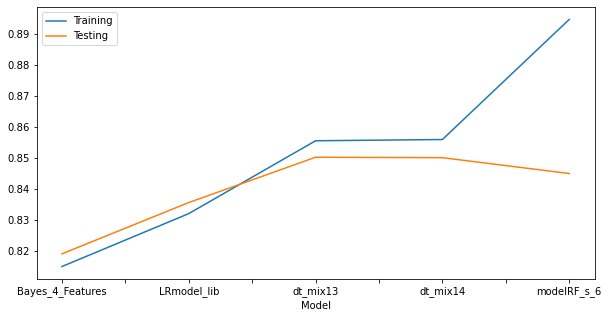

In [163]:
df_results.loc[2] = df_DT.loc[33]
df_results.loc[3] = df_DT.loc[34]

print(df_results)

df_results.set_index('Model').plot( figsize=(10, 5) )

## Random Forest:

This ML algorithm, uses decission trees, therefore does not need scaling to perform. We're going to assess in this section the performance of it with different parameters to try to find the one that suits better our problem.

Text(0.5, 1.0, 'Random Forest performance')

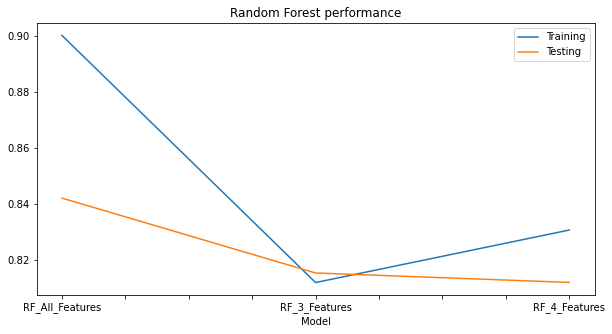

In [93]:
modelRF = RandomForestClassifier(random_state = 5)

df_rf = IndividualModel_Scoring(X_train, y_train, 
                                X_test, y_test, 
                                modelRF, 'RF_All_Features' , False)

# 3: No scaling
df_rf = df_rf.append( IndividualModel_Scoring(X_train_3, y_train, 
                                              X_test_3, y_test, 
                                              modelRF, 'RF_3_Features', False ) )


# 4: No scaling
df_rf = df_rf.append( IndividualModel_Scoring(X_train_4, y_train, 
                                              X_test_4, y_test, 
                                              modelRF, 'RF_4_Features' , False) )

df_rf.set_index(['Model']).plot( figsize=(10, 5) )
plt.title('Random Forest performance')

We see that the performance of random forests is very close to the decision trees. 

Let's change the parameters in the random forest and see the results:

In [94]:
# Number of trees
modelRF_100trees = RandomForestClassifier(n_estimators = 100, random_state = 5)
modelRF_149trees = RandomForestClassifier(n_estimators = 149, random_state = 5)
modelRF_200trees = RandomForestClassifier(n_estimators = 200, random_state = 5)
modelRF_300trees = RandomForestClassifier(n_estimators = 300, random_state = 5)

# Changing the boostrap, default = True
modelRF_b = RandomForestClassifier(bootstrap = False, random_state = 5) 

# Number of samples to draw from X to train each base estimator
modelRF_s = RandomForestClassifier(max_samples = 0.6, random_state = 5)
modelRF_s8 = RandomForestClassifier(max_samples = 0.8, random_state = 5)
modelRF_s9 = RandomForestClassifier(max_samples = 0.9, random_state = 5)

RF_to_test = [modelRF_100trees, modelRF_149trees, modelRF_200trees, modelRF_300trees, modelRF_b, 
              modelRF_s, modelRF_s8, modelRF_s9]

str_for_df = ['modelRF_100trees', 'modelRF_149trees', 'modelRF_200trees', 'modelRF_300trees', 'modelRF_b', 
              'modelRF_s', 'modelRF_s8', 'modelRF_s9']

for RF, text in zip( RF_to_test, str_for_df ):
    df_rf = df_rf.append( IndividualModel_Scoring( X_train, y_train, 
                                                   X_test, y_test, 
                                                   RF, text, False) )

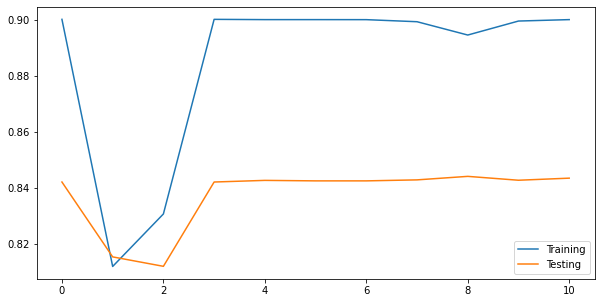

In [95]:
df_rf.reset_index(drop=True).plot( figsize=(10, 5) )

Model that overfits less:

In [96]:
modelRF_s_6 = RandomForestClassifier(n_estimators = 149, max_samples = 0.6, random_state = 5)

df_rf = df_rf.append( IndividualModel_Scoring( X_train, y_train, 
                                                   X_test, y_test, 
                                                   modelRF_s_6, 'modelRF_s_6', False) )

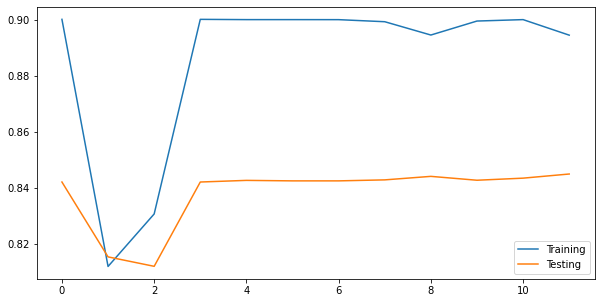

In [97]:
df_rf.reset_index(drop=True).plot( figsize=(10, 5) )

Models that overfits less:

In [98]:
df_rf.reset_index(drop=True).loc[8]

Model         modelRF_s
Scale Type     no_scale
Training       0.894626
Testing         0.84416
Name: 8, dtype: object

In [99]:
df_rf.reset_index(drop=True).loc[11]

Model         modelRF_s_6
Scale Type       no_scale
Training         0.894581
Testing          0.845002
Name: 11, dtype: object

Let's do a kFolds validation on both:

In [100]:
# 8
df_RF_score = model_scores( KFold(n_splits = 100), 
                            XX, 
                            YY, 
                            modelRF_s)

dataframe_mean_std(df_RF_score)

,Time,Training,Test
0,1.798 +/- 0.042,0.89 +/- 0.0,0.843 +/- 0.026


In [101]:
# 11
df_RF_score = model_scores( KFold(n_splits = 100), 
                            XX, 
                            YY, 
                            modelRF_s_6)

dataframe_mean_std(df_RF_score)

,Time,Training,Test
0,2.709 +/- 0.047,0.891 +/- 0.0,0.844 +/- 0.026


Both random forests have overfitting for our data. Nevertheless, let's keep 11 that has a better performance on the test dataset:

In [103]:
df_results.loc[4] = df_rf.reset_index(drop=True).loc[11]
df_results

,Model,Scale Type,Training,Testing
0,Bayes_4_Features,no_scale,0.815064,0.819154
1,LRmodel_lib,standard,0.832096,0.835658
2,dt_mix13,no_scale,0.855542,0.850236
3,dt_mix14,no_scale,0.855939,0.850098
4,modelRF_s_6,no_scale,0.894581,0.845002


## Neuronal Networks:

As we have done before let's start with a testing without scaling our data and with all the variables to see the result:

Text(0.5, 1.0, 'All features using NN')

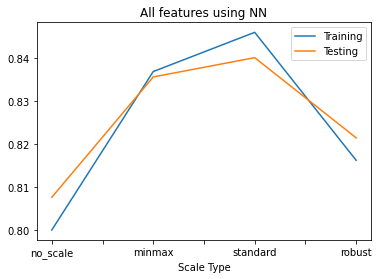

In [112]:
SimpleNN_model = MLPClassifier(random_state = 5)

# All columns without scaling:
df_NN = IndividualModel_Scoring(X_train, y_train, 
                                X_test, y_test, 
                                SimpleNN_model, 'SimpleNN_All_Features' , False)

# With scaling:
df_NN = df_NN.append( IndividualModel_Scoring(X_train, y_train, 
                                              X_test, y_test, 
                                              SimpleNN_model, 'SimpleNN_All_Features') )

df_NN.set_index('Scale Type').plot()
plt.title('All features using NN')

Let's see the performance now with less features, the ones we have been using above, such subset of the selected features have less colinearity between them:

Text(0.5, 1.0, 'NN performance')

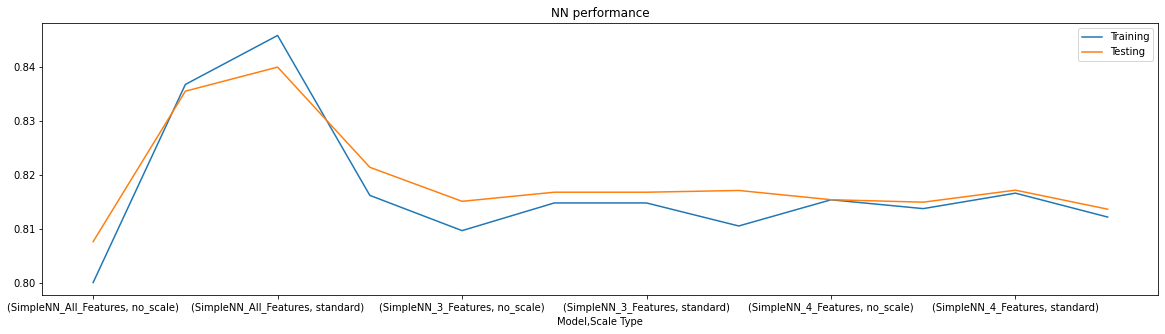

In [115]:
# 3: No scaling
df_NN = df_NN.append( IndividualModel_Scoring(X_train_3, y_train, 
                                              X_test_3, y_test, 
                                              SimpleNN_model, 'SimpleNN_3_Features' , False) )
# With scaling:
df_NN = df_NN.append( IndividualModel_Scoring(X_train_3, y_train, 
                                              X_test_3, y_test, 
                                              SimpleNN_model, 'SimpleNN_3_Features') )

# 4: No scaling
df_NN = df_NN.append( IndividualModel_Scoring(X_train_4, y_train, 
                                              X_test_4, y_test, 
                                              SimpleNN_model, 'SimpleNN_4_Features' , False) )
# With scaling:
df_NN = df_NN.append( IndividualModel_Scoring(X_train_4, y_train, 
                                              X_test_4, y_test, 
                                              SimpleNN_model, 'SimpleNN_4_Features') )

df_NN.set_index(['Model','Scale Type']).plot( figsize=(20, 5) )
plt.title('NN performance')

By looking at the graphs above we see that the minmax scaler for all the features is the one that has one of the best performances with less overfitting.

Nervertheless, let's use the standard scaler for our NN, it has a better F1 and the overfitting is not that significant to let dispense with it, it is also more stable across different datasets.

We can also set different parameters on our NN models for our scaled data:

In [130]:
# Getting the scaled data using our function
st_X_train = pd.DataFrame(scaling(X_train, X_test)[2], columns = X_train.columns )
st_X_test = pd.DataFrame(scaling(X_train, X_test)[3], columns = X_test.columns )

# NN with inner layers
NN_inner = MLPClassifier(hidden_layer_sizes = (50,100,50), random_state = 5)

# NN with inner layers and adaptive learning rate
NN_inner_adplr = MLPClassifier(hidden_layer_sizes = (50,100,50), 
                               learning_rate = 'adaptive', 
                               max_iter = 400,
                               random_state = 9)

# NN with more layers, adaptive learning rate
NN_moreinner_adplr = MLPClassifier(hidden_layer_sizes = (100,150,50,75,30), 
                                   learning_rate = 'adaptive',
                                   max_iter = 400,
                                   random_state = 9)

# NN with several inner layers and constant learning rate
NN_moreinner_constant = MLPClassifier(hidden_layer_sizes = (250,220,200), 
                                      learning_rate = 'constant',
                                      max_iter = 400,
                                      random_state = 9)

# NN with inner layers, adaptive learning rate, activation function, and solver
NN_inner_adplr_relu = MLPClassifier(hidden_layer_sizes = (250,220,200), 
                                    learning_rate = 'adaptive', 
                                    activation = 'relu',
                                    max_iter = 400,
                                    solver = 'adam',
                                    random_state = 9)

In [131]:
NN_to_test = [NN_inner, NN_inner_adplr, NN_moreinner_adplr, NN_moreinner_constant, NN_inner_adplr_relu]
str_for_df = ['NN-st_inner', 'NN-st_inner_adplr', 'NN-st_moreinner_adplr', 'NN-st_moreinner_constant',\
              'NN-st_adplr_relu']

count = 0
for NN, text in zip( NN_to_test, str_for_df ):
    df_NN = df_NN.append( IndividualModel_Scoring( st_X_train, y_train, 
                                                   st_X_test, y_test, 
                                                   NN, text, False) )
    print(count)
    count += 1

0
1
2
3
4


In [132]:
#df_NN = df_NN.reset_index(drop=True).loc[:11]

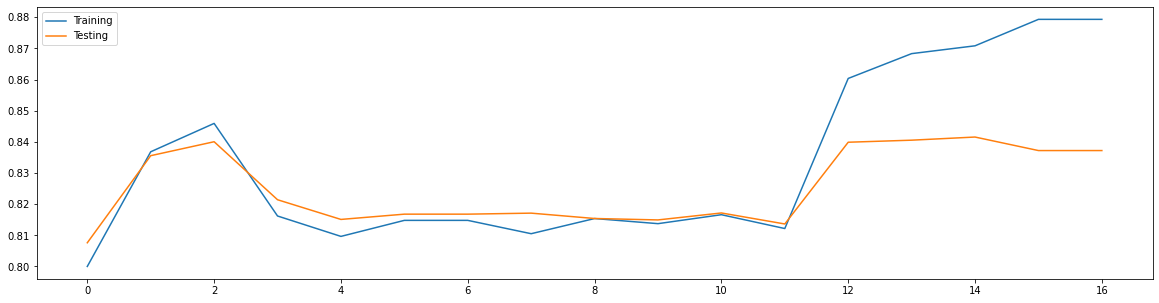

In [133]:
df_NN.reset_index(drop=True).plot( figsize=(20, 5) )

In [134]:
for nn in NN_to_test:
    print(nn, '---> Number of iterations:', nn.n_iter_)

MLPClassifier(hidden_layer_sizes=(50, 100, 50), random_state=5) ---> Number of iterations: 200
MLPClassifier(hidden_layer_sizes=(50, 100, 50), learning_rate='adaptive',
              max_iter=400, random_state=9) ---> Number of iterations: 297
MLPClassifier(hidden_layer_sizes=(100, 150, 50, 75, 30),
              learning_rate='adaptive', max_iter=400, random_state=9) ---> Number of iterations: 167
MLPClassifier(hidden_layer_sizes=(250, 220, 200), max_iter=400, random_state=9) ---> Number of iterations: 241
MLPClassifier(hidden_layer_sizes=(250, 220, 200), learning_rate='adaptive',
              max_iter=400, random_state=9) ---> Number of iterations: 241


After index 12, although F1 performance was good and the NN started a good learning process, the models started to overfit. 

In [142]:
# NN inner logistic
NN_logistic = MLPClassifier(hidden_layer_sizes = (150,100,73), 
                            activation = 'logistic',
                            max_iter = 1000,
                            random_state = 5)

# NN inner tanh
NN_tanh = MLPClassifier(hidden_layer_sizes = (150,100,73), 
                        activation = 'tanh', 
                        max_iter = 1000,
                        random_state = 5)

# NN learning rate invscaling
NN_learn_inv = MLPClassifier(hidden_layer_sizes = (150,100,73), 
                             learning_rate = 'invscaling',
                             max_iter = 1000,
                             random_state = 5)

NN_to_test = [NN_logistic, 
              NN_tanh, 
              NN_learn_inv]

str_for_df = ['NN_st_logistic1000', 
              'NN_st_tanh1000', 
              'NN_st_learn_inv1000']

In [143]:
count = 0
for NN, text in zip( NN_to_test, str_for_df ):
    df_NN = df_NN.append( IndividualModel_Scoring( st_X_train, y_train, 
                                                   st_X_test, y_test, 
                                                   NN, text, False) )
    print(count)
    count += 1

0
1
2


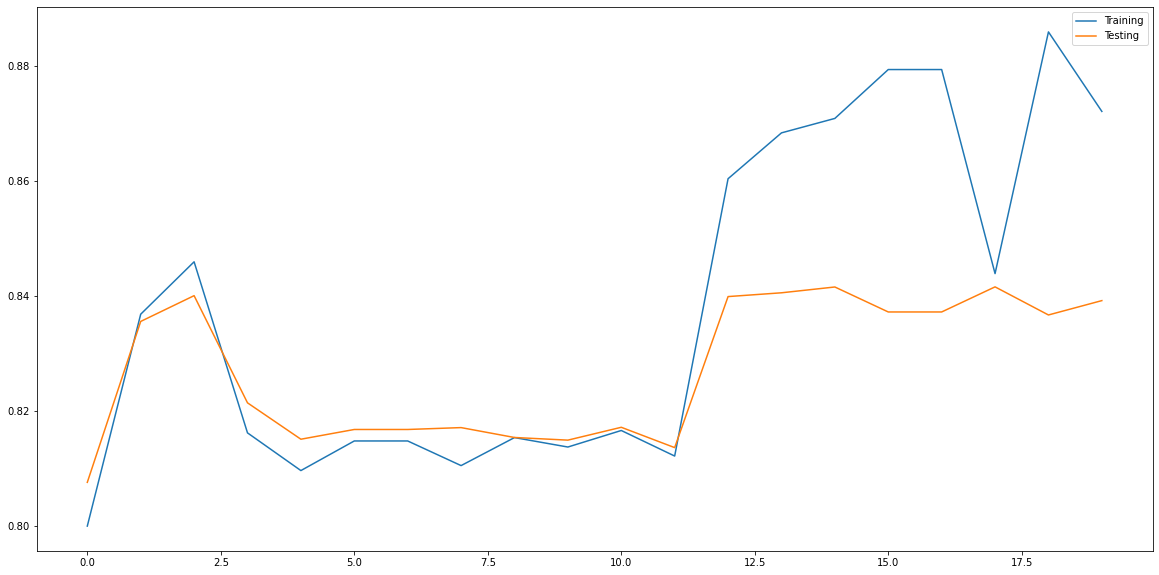

In [145]:
df_NN.reset_index(drop=True, inplace=True)
df_NN.plot( figsize=(20, 10) )

In [146]:
for nn in NN_to_test:
    print(nn, '---> Number of iterations:', nn.n_iter_)

MLPClassifier(activation='logistic', hidden_layer_sizes=(150, 100, 73),
              max_iter=1000, random_state=5) ---> Number of iterations: 164
MLPClassifier(activation='tanh', hidden_layer_sizes=(150, 100, 73),
              max_iter=1000, random_state=5) ---> Number of iterations: 423
MLPClassifier(hidden_layer_sizes=(150, 100, 73), learning_rate='invscaling',
              max_iter=1000, random_state=5) ---> Number of iterations: 246


The performance did not increased much for those last NN models, the overfitting did not improved for some models either.

Some models are worth to be considered. Let's assess them by using kFolds:

In [149]:
df_NN.loc[13]

Model         NN-st_inner_adplr
Scale Type             no_scale
Training               0.868327
Testing                0.840541
Name: 13, dtype: object

In [157]:
df_NN.loc[14]

Model         NN-st_moreinner_adplr
Scale Type                 no_scale
Training                   0.870838
Testing                     0.84155
Name: 14, dtype: object

In [154]:
df_NN.loc[17]

Model         NN_st_logistic1000
Scale Type              no_scale
Training                0.843876
Testing                 0.841571
Name: 17, dtype: object

In [155]:
# For 13
df_NN_score = model_scores( KFold(n_splits = 10), 
                            XX, 
                            YY, 
                            NN_inner_adplr,
                            StandardScaler())

dataframe_mean_std(df_NN_score)

,Time,Training,Test
0,169.775 +/- 44.479,0.862 +/- 0.004,0.839 +/- 0.009


In [158]:
# For 14
df_NN_score = model_scores( KFold(n_splits = 10), 
                            XX, 
                            YY, 
                            NN_moreinner_adplr,
                            StandardScaler())

dataframe_mean_std(df_NN_score)

,Time,Training,Test
0,240.451 +/- 73.618,0.869 +/- 0.004,0.838 +/- 0.005


In [159]:
# For 17
df_NN_score = model_scores( KFold(n_splits = 10), 
                            XX, 
                            YY, 
                            NN_logistic,
                            StandardScaler())

dataframe_mean_std(df_NN_score)

,Time,Training,Test
0,89.406 +/- 66.318,0.841 +/- 0.006,0.839 +/- 0.008


Then, we're going to stay with the NN model 17, that has a better performance for the test dataset and a running speed.

In [160]:
#df_NN = pd.read_csv(NN_results.csv)
#df_NN.to_csv('NN_results.csv', index=False)

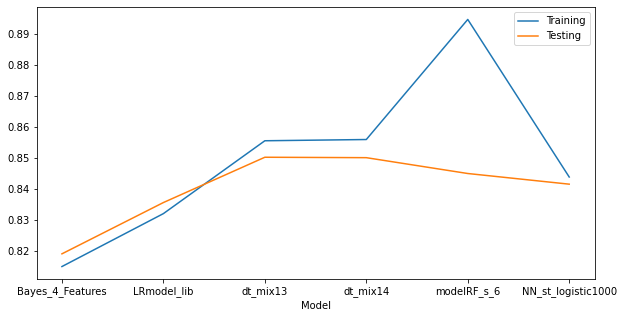

In [170]:
df_results.loc[5] = df_NN.reset_index(drop = True).loc[17]

df_results.set_index('Model').plot( figsize=(10, 5) )

##### ===================================

We have succesfully tested several models against our data and got good performances out of them. For some, we have lower/higher performance, more/lesss overfitting. But we could start grouping this classifiers together to get a better performance.

##### ===================================

## Bagging Classifier:

Let's use a bagging for a KNN algorithm on our dataset:

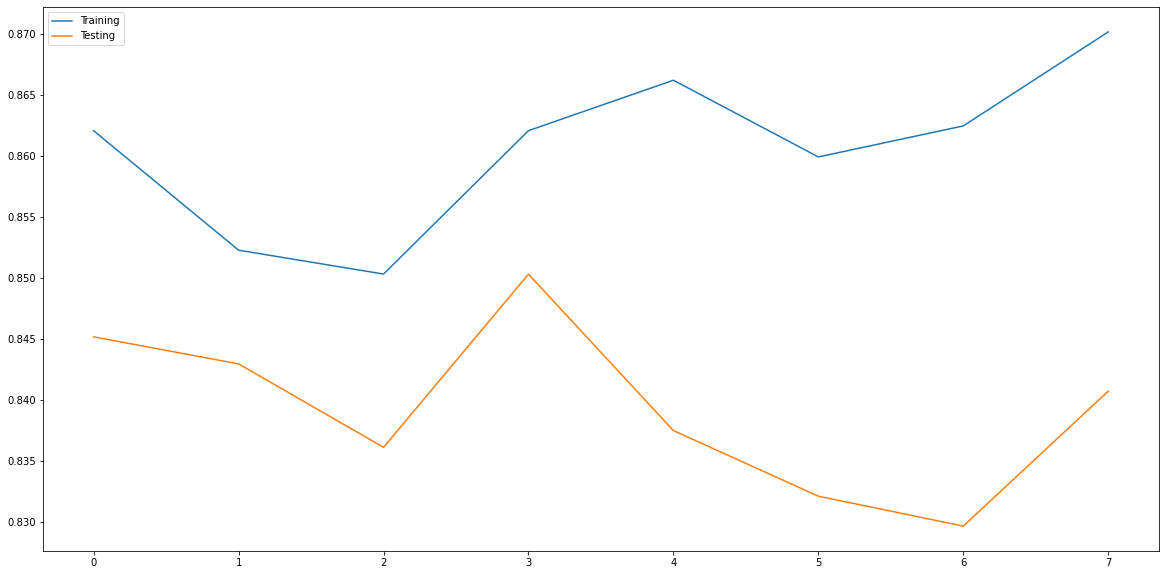

In [171]:
# Bootstraping
bagging_KNN_bt = BaggingClassifier(base_estimator = KNeighborsClassifier(), random_state = 5, bootstrap_features = True)

# No Bootstraping
bagging_KNN = BaggingClassifier(base_estimator = KNeighborsClassifier(), random_state = 5)



df_b = IndividualModel_Scoring( X_train, y_train, 
                                X_test, y_test, 
                                bagging_KNN_bt, 'bagging_KNN_bt' , False)

df_b = df_b.append( IndividualModel_Scoring(X_train, y_train, 
                                            X_test, y_test, 
                                            bagging_KNN_bt, 'bagging_KNN_bt' ) )


df_b = df_b.append( IndividualModel_Scoring(X_train, y_train, 
                                            X_test, y_test, 
                                            bagging_KNN, 'bagging_KNN', False ) )

df_b = df_b.append( IndividualModel_Scoring(X_train, y_train, 
                                            X_test, y_test, 
                                            bagging_KNN, 'bagging_KNN' ) )

df_b.reset_index(drop=True, inplace=True)
df_b.plot( figsize=(20, 10) )

In [173]:
df_b.loc[3]

Model         bagging_KNN_bt
Scale Type            robust
Training            0.862065
Testing             0.850305
Name: 3, dtype: object

Let's do a bagging of our logistic regression classifier with the best result (use the standard scaling, it got us the best performance out of the classifier)

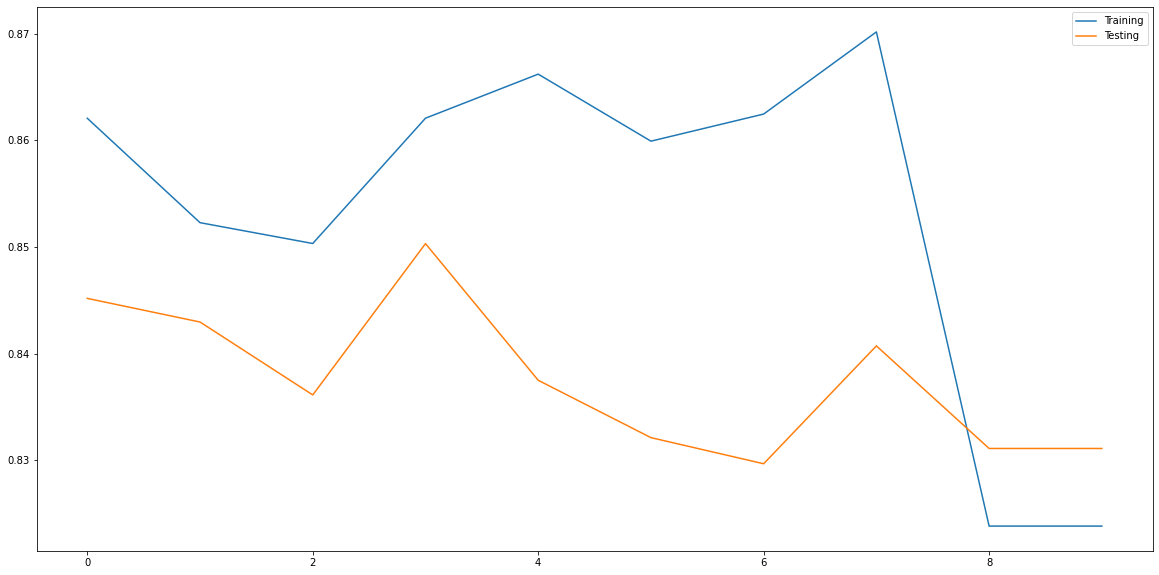

In [179]:
# Logistic regression, no boostraping
bagging_lr = BaggingClassifier(base_estimator = LRmodel_lib, random_state = 5)

# Logistic regression
bagging_lr = BaggingClassifier(base_estimator = LRmodel_lib, random_state = 5, bootstrap_features = True)

#StandardScaler()

b_to_test = [bagging_lr, bagging_lr]

str_for_df = ['bagging_lr', 'bagging_lr']

for B, text in zip( b_to_test, str_for_df ):
    df_b = df_b.append( IndividualModel_Scoring( st_X_train, y_train, 
                                                 st_X_test, y_test, 
                                                 B , text, False) )

df_b.reset_index(drop=True, inplace=True)
df_b.plot( figsize=(20, 10) )

The results of the Logistic Regression are not that good. Let's do a bagging of our best model so far, the decission trees mix13 and mix14:

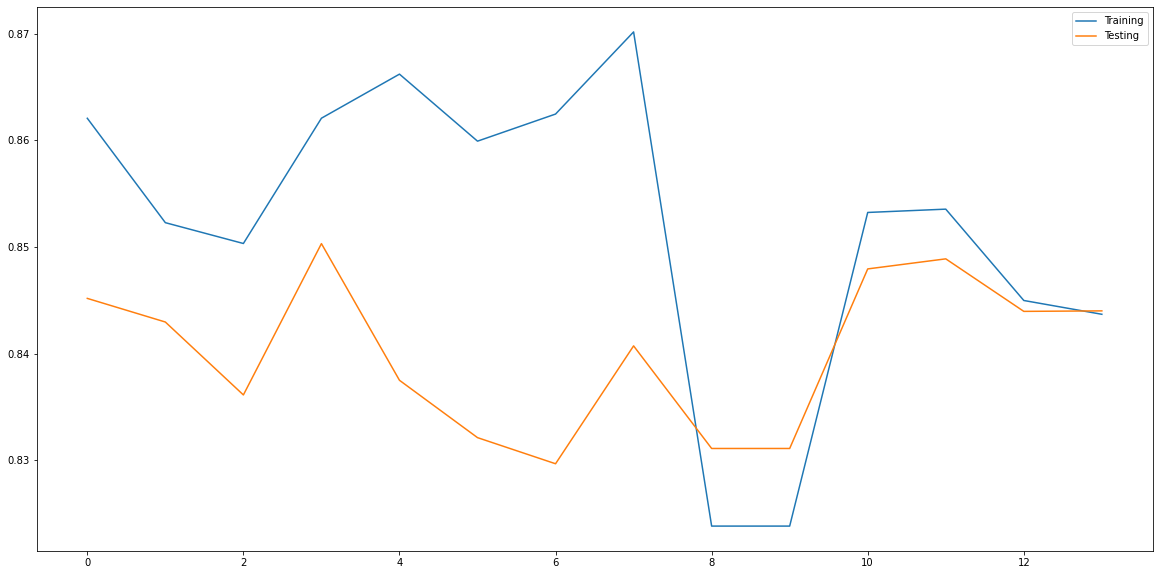

In [180]:
bagging_mix13 = BaggingClassifier(base_estimator = dt_mix13, random_state = 5)

bagging_mix14 = BaggingClassifier(base_estimator = dt_mix14, random_state = 5)

bagging_mix13_b = BaggingClassifier(base_estimator = dt_mix13, random_state = 5, bootstrap_features = True)

bagging_mix14_b = BaggingClassifier(base_estimator = dt_mix14, random_state = 5, bootstrap_features = True)

b_to_test = [bagging_mix13, bagging_mix14, bagging_mix13_b, bagging_mix14_b]

str_for_df = ['bagging_mix13', 'bagging_mix14', 'bagging_mix13_b', 'bagging_mix14_b']


for B, text in zip( b_to_test, str_for_df ):
    df_b = df_b.append( IndividualModel_Scoring( X_train, y_train, 
                                                 X_test, y_test, 
                                                 B , text, False) )

df_b.reset_index(drop=True, inplace=True)
df_b.plot( figsize=(20, 10) )

In [183]:
df_b.loc[3]

Model         bagging_KNN_bt
Scale Type            robust
Training            0.862065
Testing             0.850305
Name: 3, dtype: object

In [184]:
df_b.loc[11]

Model         bagging_mix14
Scale Type         no_scale
Training           0.853537
Testing            0.848877
Name: 11, dtype: object

We have the best two performances of the bagging classifiers for:

* The dt_mix14 (but almost the same than for the dt alone).
* The bagging KNN with bootstrapping.

Let's check the optimal n_estimators for the classifiers for each one (default = 10)

#### mix14:

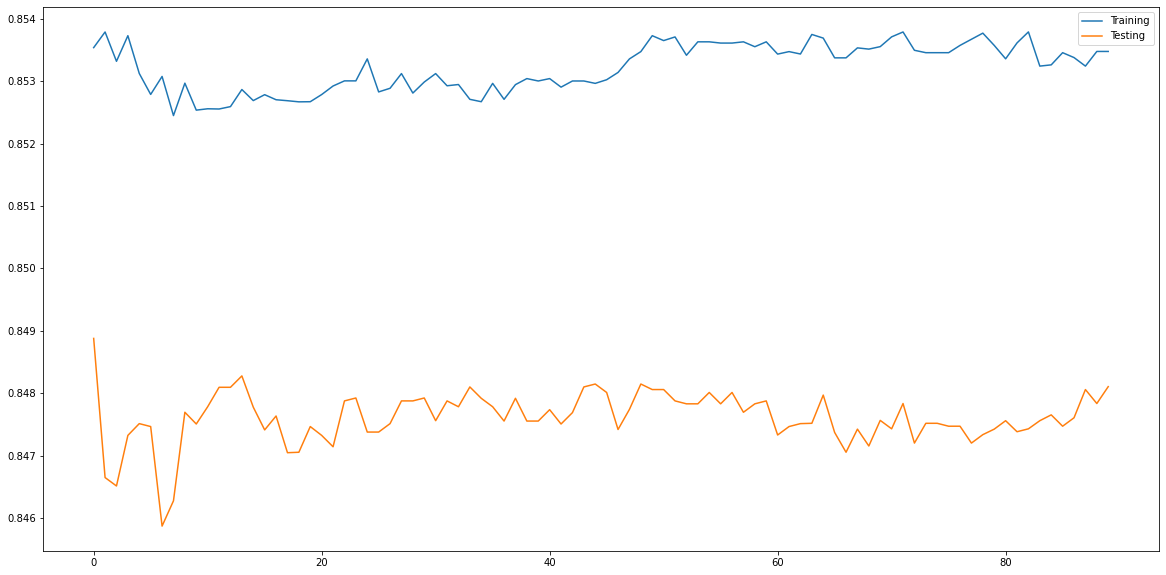

In [194]:
for N in range(10, 100):
    bagging_mix14 = BaggingClassifier(base_estimator = dt_mix14, random_state = 5, n_estimators = N)
    
    step = 'bagging_mix14_' + str(N)
    
    if N == 10:
        df_b_mix14_N = IndividualModel_Scoring( X_train, y_train, 
                                                 X_test, y_test, 
                                                 bagging_mix14 , step, False)
    else:
        df_b_mix14_N = df_b_mix14_N.append( IndividualModel_Scoring( X_train, y_train, 
                                                                     X_test, y_test, 
                                                                     bagging_mix14 , step, False) )

df_b_mix14_N.reset_index(drop=True, inplace=True)
df_b_mix14_N.plot( figsize=(20, 10) )

By looking at the graph above, increasing the number of estimators won't improve the performance of the bagging classifier ussing dt_mix14.

The dt_mix14 by itself proves to be a better estimate than the bagging.

####  Bagging KNN with bootstrapping:

In [195]:
rb_X_train = scaling(X_train, X_test)[4]
rb_X_test = scaling(X_train, X_test)[5]

In [198]:
for N in range(10, 100):
    bagging_KNN_bt_N = BaggingClassifier(base_estimator = KNeighborsClassifier(), 
                                         bootstrap_features = True, 
                                         random_state = 5, 
                                         n_estimators = N)
    
    step = 'bagging_KNN_bt_' + str(N)
    
    if N == 10:
        df_b_knn_N = IndividualModel_Scoring( rb_X_train, y_train, 
                                              rb_X_test, y_test, 
                                              bagging_KNN_bt , step, False)
    else:
        df_b_knn_N = df_b_knn_N.append( IndividualModel_Scoring( rb_X_train, y_train, 
                                                                 rb_X_test, y_test, 
                                                                 bagging_KNN_bt , step, False) )

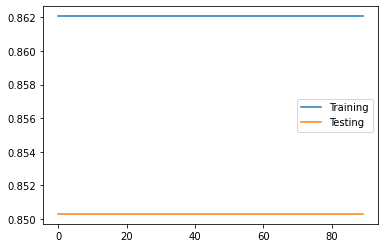

In [199]:
df_b_knn_N.reset_index(drop=True, inplace=True)
df_b_knn_N.plot(  )

In this case, changing the estimators did not improve the performance of the KNN bagging with bootstrapping.

This will be our choice to save in the results DataFrame. Let's validate by using a kFolds:

In [ ]:
# For KNN with bt + robust scaling
df_bg_score = model_scores( KFold(n_splits = 10), 
                            XX, 
                            YY, 
                            bagging_KNN_bt,
                            RobustScaler())

dataframe_mean_std(df_bg_score)

Let's append to our results dataframe:

                Model Scale Type  Training   Testing
0    Bayes_4_Features   no_scale  0.815064  0.819154
1         LRmodel_lib   standard  0.832096  0.835658
2            dt_mix13   no_scale  0.855542  0.850236
3            dt_mix14   no_scale  0.855939  0.850098
4         modelRF_s_6   no_scale  0.894581  0.845002
5  NN_st_logistic1000   no_scale  0.843876  0.841571
6      bagging_KNN_bt     robust  0.862065  0.850305


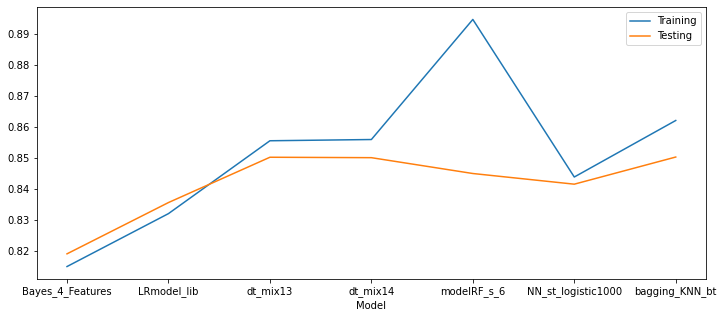

In [203]:
df_results.loc[6] = df_b.loc[3]

print(df_results)

df_results.set_index('Model', 'Scale Type').plot( figsize=(12, 5) )

## Adaboost Classifier:

Is based on DT, no scaling needed:

In [216]:
model_ada = AdaBoostClassifier(random_state = 5)

df_ada = IndividualModel_Scoring(X_train, y_train, 
                                 X_test, y_test, 
                                 model_ada, 'ada_All_Features' , False)
df_ada

,Model,Scale Type,Training,Testing
0,ada_All_Features,no_scale,0.847115,0.844924


Let's test:

#### n_estimators:

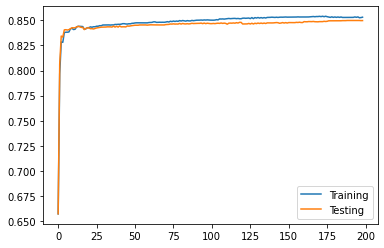

In [225]:
num_estimators = list(range(1,380))

for N in num_estimators:
    
    model_ada_N = AdaBoostClassifier(n_estimators = N, random_state = 5)
    
    step = 'model_ada_' + str(N)
    
    if N == 1:
        df_ada_N = IndividualModel_Scoring( X_train, y_train, 
                                            X_test, y_test, 
                                            model_ada_N , step, False)
    else:
        df_ada_N = df_ada_N.append( IndividualModel_Scoring( X_train, y_train, 
                                                             X_test, y_test, 
                                                             model_ada_N , step, False) )

df_ada_N.reset_index(drop=True, inplace=True)
df_ada_N.plot()

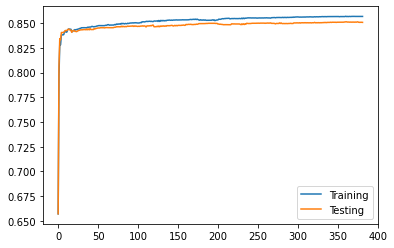

In [250]:
df_ada_N.reset_index(drop=True, inplace=True)
df_ada_N.plot()

In [251]:
# Where we reach the max:
df_ada_N[ df_ada_N['Testing'] == df_ada_N.Testing.max() ]

,Model,Scale Type,Training,Testing
359,model_ada_360,no_scale,0.856692,0.851364
361,model_ada_362,no_scale,0.856692,0.851364
375,model_ada_376,no_scale,0.856770,0.851364


We will choose 194 estimators

#### Learning rate:

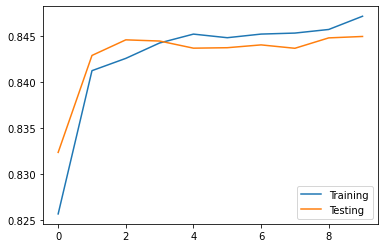

In [240]:
learning_rate = list(np.linspace(0.1, 0.9, 9, endpoint=True)) + [1.0]

for L in learning_rate:
    
    model_ada_lrate = AdaBoostClassifier(learning_rate = L, random_state = 5)
    
    step = 'model_ada_lrate_' + str(L)
    
    if L == 0.1:
        df_ada_lrate = IndividualModel_Scoring( X_train, y_train, 
                                            X_test, y_test, 
                                            model_ada_lrate , step, False)
    else:
        df_ada_lrate = df_ada_lrate.append( IndividualModel_Scoring( X_train, y_train, 
                                                             X_test, y_test, 
                                                             model_ada_lrate , step, False) )

df_ada_lrate.reset_index(drop=True, inplace=True)
df_ada_lrate.plot()

We can see that the best learning rate is 1, which is the default value.

Let's keep the adaboost when we have 360 estimators and do a kFolds validation on it:

In [259]:
model_ada_final = AdaBoostClassifier(n_estimators = 360, random_state = 5)

In [ ]:
# For KNN with bt + robust scaling
df_ada_score = model_scores( KFold(n_splits = 10), 
                             XX, 
                             YY, 
                             model_ada_final)

dataframe_mean_std(df_ada_score)

We then select as the one with better performance:

In [265]:
df_ada = df_ada.append( IndividualModel_Scoring( X_train, y_train, 
                                                 X_test, y_test, 
                                                 model_ada_final, 'model_ada_final', False) )

df_ada.reset_index(inplace=True, drop=True)

In [266]:
df_ada

,Model,Scale Type,Training,Testing
0,ada_All_Features,no_scale,0.847115,0.844924
1,model_ada_final,no_scale,0.856692,0.851364


                Model Scale Type  Training   Testing
0    Bayes_4_Features   no_scale  0.815064  0.819154
1         LRmodel_lib   standard  0.832096  0.835658
2            dt_mix13   no_scale  0.855542  0.850236
3            dt_mix14   no_scale  0.855939  0.850098
4         modelRF_s_6   no_scale  0.894581  0.845002
5  NN_st_logistic1000   no_scale  0.843876  0.841571
6      bagging_KNN_bt     robust  0.862065  0.850305
7     model_ada_final   no_scale  0.856692  0.851364


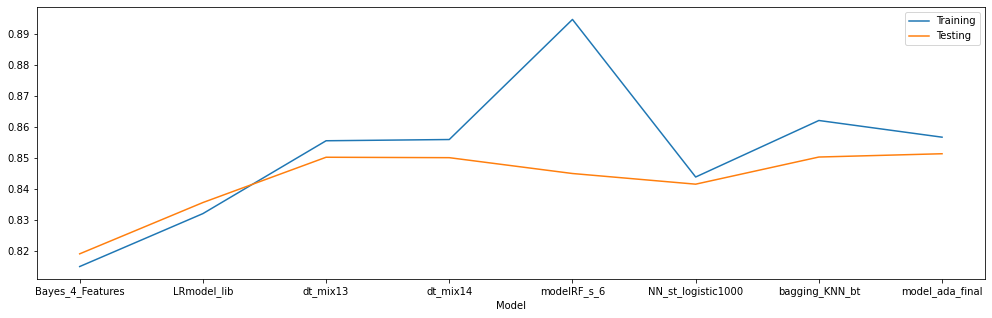

In [267]:
df_results.loc[7] = df_ada.loc[1] 

print(df_results)

df_results.set_index('Model', 'Scale Type').plot( figsize=(17, 5) )

## Gradient Boost:

In [278]:
model_gb_basic = GradientBoostingClassifier(random_state = 5)

df_gb = IndividualModel_Scoring( X_train, y_train, 
                                 X_test, y_test, 
                                 model_gb_basic, 'model_gb_basic' , False)

model_gb_mse
model_gb_sb7
model_gb_sb8
model_gb_sb9


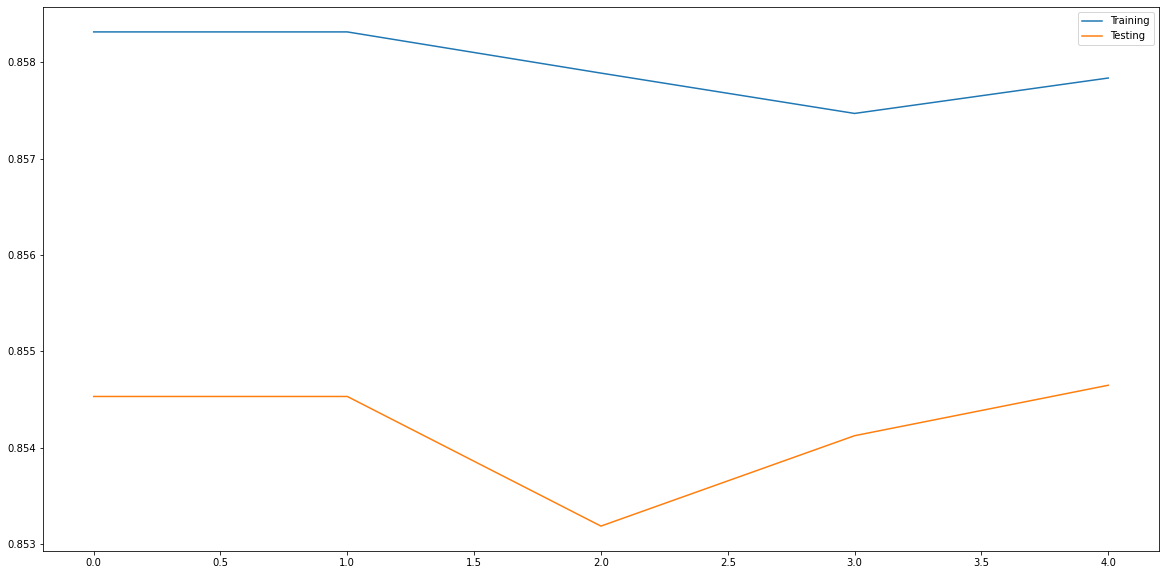

In [279]:
model_gb_mse = GradientBoostingClassifier(random_state = 5, criterion = 'mse')

model_gb_sb7 = GradientBoostingClassifier(random_state = 5, subsample = 0.7)
model_gb_sb8 = GradientBoostingClassifier(random_state = 5, subsample = 0.8)
model_gb_sb9 = GradientBoostingClassifier(random_state = 5, subsample = 0.9)

gb_to_test = [model_gb_mse, model_gb_sb7, model_gb_sb8, model_gb_sb9]

str_for_df = ['model_gb_mse', 'model_gb_sb7', 'model_gb_sb8', 'model_gb_sb9']


for gb, text in zip( gb_to_test, str_for_df ):
    
    df_gb = df_gb.append( IndividualModel_Scoring( X_train, y_train, 
                                                   X_test, y_test, 
                                                   gb , text, False) )
    print(text)

df_gb.reset_index(drop=True, inplace=True)
df_gb.plot( figsize=(20, 10) )

Testing the number of estimators for the subsample 0.9 to see if there's a better performance:

Acording to the documentation, there's a tradeoff for this parameter when used with learning rate, let's keep the default larning rate.

150
210
300
350


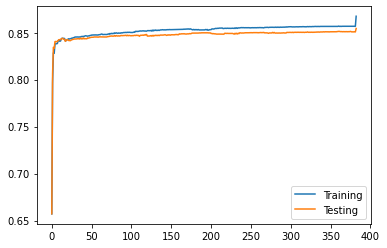

In [296]:
num_estimators = list(range(100,400))

for N in num_estimators:
    
    model_gb_N = GradientBoostingClassifier(n_estimators = N, subsample = 0.9 , random_state = 5)
    
    step = 'model_gb_' + str(N)
    
    if N == 100:
        df_gb_N = IndividualModel_Scoring( X_train, y_train, 
                                            X_test, y_test, 
                                            model_gb_N , step, False)
    else:
        df_gb_N = df_ada_N.append( IndividualModel_Scoring( X_train, y_train, 
                                                             X_test, y_test, 
                                                             model_gb_N , step, False) )
    
    if N in [150, 210, 300, 350]:
        print(N)


df_gb_N.reset_index(drop=True, inplace=True)
df_gb_N.plot()

In [297]:
df_gb_N[df_gb_N.Testing == df_gb_N.Testing.max() ]

,Model,Scale Type,Training,Testing
382,model_gb_379,no_scale,0.867507,0.854479


Different estimation but for the learning_rate:

410
430
470


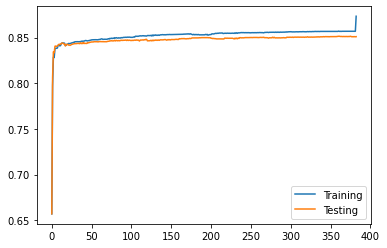

In [286]:
num_estimators = list(range(400,500))

for N in num_estimators:
    
    model_gb_N = GradientBoostingClassifier(n_estimators = N, learning_rate = 0.2 , random_state = 5)
    
    step = 'model_gb_' + str(N)
    
    if N == 100:
        df_gb_N = IndividualModel_Scoring( X_train, y_train, 
                                            X_test, y_test, 
                                            model_gb_N , step, False)
    else:
        df_gb_N = df_ada_N.append( IndividualModel_Scoring( X_train, y_train, 
                                                             X_test, y_test, 
                                                             model_gb_N , step, False) )
    
    if N in [410, 430, 470]:
        print(N)


df_gb_N.reset_index(drop=True, inplace=True)
df_gb_N.plot()

Second part using the learning rate did not improve. As you see below:

In [287]:
df_gb_N[df_gb_N.Testing == df_gb_N.Testing.max() ]

,Model,Scale Type,Training,Testing
359,model_ada_360,no_scale,0.856692,0.851364
361,model_ada_362,no_scale,0.856692,0.851364
375,model_ada_376,no_scale,0.856770,0.851364


The best choice is the n_estimators = 379, sumbsample = 0.9

Appending to our df:

In [302]:
model_gboost_nestm = GradientBoostingClassifier(n_estimators = 379, subsample = 0.9 , random_state = 5)

In [303]:
df_gb = df_gb.append( IndividualModel_Scoring( X_train, y_train, 
                                               X_test, y_test, 
                                               model_gboost_nestm , 'model_gboost_nestm', False) )
df_gb

,Model,Scale Type,Training,Testing
0,model_gb_basic,no_scale,0.858316,0.854532
1,model_gb_mse,no_scale,0.858316,0.854532
2,model_gb_sb7,no_scale,0.857888,0.853187
3,model_gb_sb8,no_scale,0.857469,0.854125
4,model_gb_sb9,no_scale,0.857837,0.854648
0,model_gboost_nestm,no_scale,0.867507,0.854479


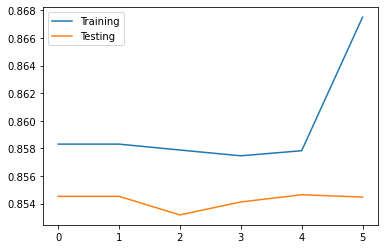

In [304]:
df_gb.reset_index(drop=True).plot()

Our performance does not increase much, we will stick with: model_gb_sb9

Let's do a kFolds validation:

In [292]:
# For gboost:
df_ada_score = model_scores( KFold(n_splits = 10), 
                             XX, 
                             YY, 
                             model_gb_sb9)

dataframe_mean_std(df_ada_score)

,Time,Training,Test
0,1.475 +/- 0.089,0.856 +/- 0.001,0.852 +/- 0.01


In [305]:
df_gb

,Model,Scale Type,Training,Testing
0,model_gb_basic,no_scale,0.858316,0.854532
1,model_gb_mse,no_scale,0.858316,0.854532
2,model_gb_sb7,no_scale,0.857888,0.853187
3,model_gb_sb8,no_scale,0.857469,0.854125
4,model_gb_sb9,no_scale,0.857837,0.854648
0,model_gboost_nestm,no_scale,0.867507,0.854479


                Model Scale Type  Training   Testing
0    Bayes_4_Features   no_scale  0.815064  0.819154
1         LRmodel_lib   standard  0.832096  0.835658
2            dt_mix13   no_scale  0.855542  0.850236
3            dt_mix14   no_scale  0.855939  0.850098
4         modelRF_s_6   no_scale  0.894581  0.845002
5  NN_st_logistic1000   no_scale  0.843876  0.841571
6      bagging_KNN_bt     robust  0.862065  0.850305
7     model_ada_final   no_scale  0.856692  0.851364
8        model_gb_sb9   no_scale  0.857837  0.854648


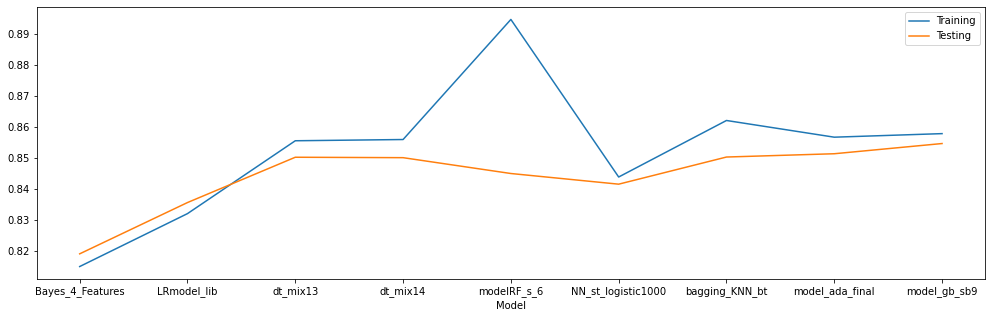

In [306]:
df_results.loc[8] = df_gb.loc[4] 

print(df_results)

df_results.set_index('Model', 'Scale Type').plot( figsize=(17, 5) )

In [307]:
#df_results.to_csv('ModelsResults(Missing_Bagging).csv')

## Stacking Classifiers:

Looking at the graph above, we know which models perform better for our data. Let's start stacking the classifiers and check for performance improvements.

In [308]:
# Creating a copy of the results to check in graphs separately 
df_results_tocheck = df_results.copy()

Let's print all the models:

In [317]:
LRmodel_lib

LogisticRegression(max_iter=300, solver='liblinear')

In [318]:
dt_mix13 

DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=100)

In [312]:
dt_mix14 

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10,
                       min_samples_split=100)

In [319]:
modelRF_s_6 

RandomForestClassifier(max_samples=0.6, n_estimators=149, random_state=5)

In [325]:
#NN_st_logistic1000
NN_logistic 

MLPClassifier(activation='logistic', hidden_layer_sizes=(150, 100, 73),
              max_iter=1000, random_state=5)

In [313]:
bagging_KNN_bt 

BaggingClassifier(base_estimator=KNeighborsClassifier(),
                  bootstrap_features=True, random_state=5)

In [323]:
model_ada_final 

AdaBoostClassifier(n_estimators=360, random_state=5)

In [324]:
model_gb_sb9 

GradientBoostingClassifier(random_state=5, subsample=0.9)

In [326]:
df_results

,Model,Scale Type,Training,Testing
0,Bayes_4_Features,no_scale,0.815064,0.819154
1,LRmodel_lib,standard,0.832096,0.835658
2,dt_mix13,no_scale,0.855542,0.850236
3,dt_mix14,no_scale,0.855939,0.850098
4,modelRF_s_6,no_scale,0.894581,0.845002
5,NN_st_logistic1000,no_scale,0.843876,0.841571
6,bagging_KNN_bt,robust,0.862065,0.850305
7,model_ada_final,no_scale,0.856692,0.851364
8,model_gb_sb9,no_scale,0.857837,0.854648


#### ============================================================

In [329]:
estimators = [ ('dt_mix14', dt_mix14 ),
               ('bagging_KNN_bt', bagging_KNN_bt )]

sc_mix14_knn = StackingClassifier(estimators=estimators, final_estimator = LogisticRegression() )

In [330]:
# Scaling the data:
rb_X_train = scaling(X_train, X_test)[4]
rb_X_test = scaling(X_train, X_test)[5]

df_stacking = IndividualModel_Scoring( rb_X_train, y_train, 
                                       rb_X_test, y_test, 
                                       sc_mix14_knn , 'sc_mix14_knn', False)

df_stacking

,Model,Scale Type,Training,Testing
0,sc_mix14_knn,no_scale,0.868458,0.856355


In [332]:
estimators = [ ('dt_mix14', dt_mix14 ),
               ('bagging_KNN_bt', bagging_KNN_bt )]

sc_mix14_knn_lr = StackingClassifier(estimators=estimators, final_estimator = LRmodel_lib )

df_stacking = df_stacking.append( IndividualModel_Scoring( rb_X_train, y_train, 
                                                           rb_X_test, y_test, 
                                                           sc_mix14_knn_lr , 'sc_mix14_knn_lr', False) )

df_stacking

,Model,Scale Type,Training,Testing
0,sc_mix14_knn,no_scale,0.868458,0.856355
0,sc_mix14_knn_lr,no_scale,0.868458,0.856705


In [333]:
estimators = [ ('model_ada_final', model_ada_final ),
               ('bagging_KNN_bt', bagging_KNN_bt ), 
               ('model_gb_sb9', model_gb_sb9) ]

sc_best3 = StackingClassifier(estimators=estimators, final_estimator = LRmodel_lib )

df_stacking = df_stacking.append( IndividualModel_Scoring( rb_X_train, y_train, 
                                                           rb_X_test, y_test, 
                                                           sc_best3 , 'sc_best3', False) )

df_stacking

,Model,Scale Type,Training,Testing
0,sc_mix14_knn,no_scale,0.868458,0.856355
0,sc_mix14_knn_lr,no_scale,0.868458,0.856705
0,sc_best3,no_scale,0.863242,0.858118


In [335]:
estimators = [ ('model_ada_final', model_ada_final ),
               ('bagging_KNN_bt', bagging_KNN_bt ), 
               ('model_gb_sb9', model_gb_sb9), 
               ('NN_st_logistic', NN_logistic) ]

sc_best4 = StackingClassifier(estimators=estimators, final_estimator = LRmodel_lib )

df_stacking = df_stacking.append( IndividualModel_Scoring( X_train, y_train, 
                                                           X_test, y_test, 
                                                           sc_best4 , 'sc_best4') )

df_stacking

,Model,Scale Type,Training,Testing
0,sc_mix14_knn,no_scale,0.868458,0.856355
0,sc_mix14_knn_lr,no_scale,0.868458,0.856705
0,sc_best3,no_scale,0.863242,0.858118
0,sc_best4,minmax,0.856882,0.854932
1,sc_best4,standard,0.859022,0.854520
2,sc_best4,robust,0.863284,0.857941


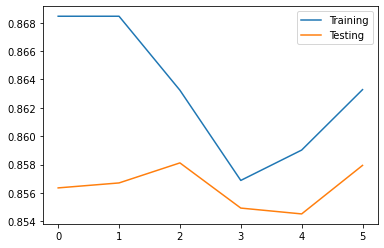

In [336]:
df_stacking.reset_index(drop=True).plot()

Clearly, the best 3 give us a good performance (already scaled for robust), followed by the best4 with robust scaler, let's use the best3 with a different final estimator:

In [338]:
estimators = [ ('model_ada_final', model_ada_final ),
               ('bagging_KNN_bt', bagging_KNN_bt ), 
               ('model_gb_sb9', model_gb_sb9) ]

sc_best3_fest_mix14 = StackingClassifier(estimators=estimators, final_estimator = dt_mix14 )

df_stacking = df_stacking.append( IndividualModel_Scoring( rb_X_train, y_train, 
                                                           rb_X_test, y_test, 
                                                           sc_best3_fest_mix14 , 'sc_best3_fest_mix14', False) )

df_stacking

,Model,Scale Type,Training,Testing
0,sc_mix14_knn,no_scale,0.868458,0.856355
0,sc_mix14_knn_lr,no_scale,0.868458,0.856705
0,sc_best3,no_scale,0.863242,0.858118
0,sc_best4,minmax,0.856882,0.854932
1,sc_best4,standard,0.859022,0.854520
2,sc_best4,robust,0.863284,0.857941
0,sc_best3_fest_mix14,no_scale,0.849827,0.847018


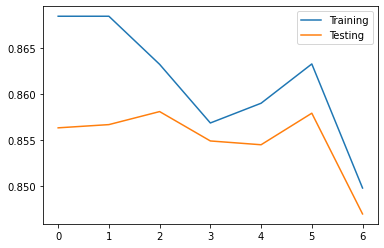

In [339]:
df_stacking.reset_index(drop=True).plot()

In [340]:
estimators = [ ('model_ada_final', model_ada_final ),
               ('bagging_KNN_bt', bagging_KNN_bt ), 
               ('model_gb_sb9', model_gb_sb9) ]

sc_best3_fest_NN = StackingClassifier(estimators=estimators, final_estimator = NN_logistic )

df_stacking = df_stacking.append( IndividualModel_Scoring( rb_X_train, y_train, 
                                                           rb_X_test, y_test, 
                                                           sc_best3_fest_NN , 'sc_best3_fest_NN', False) )

df_stacking

,Model,Scale Type,Training,Testing
0,sc_mix14_knn,no_scale,0.868458,0.856355
0,sc_mix14_knn_lr,no_scale,0.868458,0.856705
0,sc_best3,no_scale,0.863242,0.858118
0,sc_best4,minmax,0.856882,0.854932
1,sc_best4,standard,0.859022,0.854520
2,sc_best4,robust,0.863284,0.857941
0,sc_best3_fest_mix14,no_scale,0.849827,0.847018
0,sc_best3_fest_NN,no_scale,0.863587,0.858122


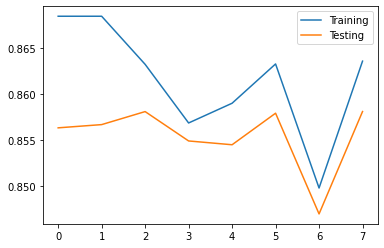

In [341]:
df_stacking.reset_index(drop=True).plot()

In [342]:
estimators = [ ('model_ada_final', model_ada_final ),
               ('bagging_KNN_bt', bagging_KNN_bt ), 
               ('model_gb_sb9', model_gb_sb9) ]

sc_best3_fest_gb = StackingClassifier(estimators=estimators, final_estimator = model_gb_sb9 )

df_stacking = df_stacking.append( IndividualModel_Scoring( rb_X_train, y_train, 
                                                           rb_X_test, y_test, 
                                                           sc_best3_fest_gb , 'sc_best3_fest_gb', False) )

df_stacking

,Model,Scale Type,Training,Testing
0,sc_mix14_knn,no_scale,0.868458,0.856355
0,sc_mix14_knn_lr,no_scale,0.868458,0.856705
0,sc_best3,no_scale,0.863242,0.858118
0,sc_best4,minmax,0.856882,0.854932
1,sc_best4,standard,0.859022,0.854520
2,sc_best4,robust,0.863284,0.857941
0,sc_best3_fest_mix14,no_scale,0.849827,0.847018
0,sc_best3_fest_NN,no_scale,0.863587,0.858122
0,sc_best3_fest_gb,no_scale,0.860053,0.854084


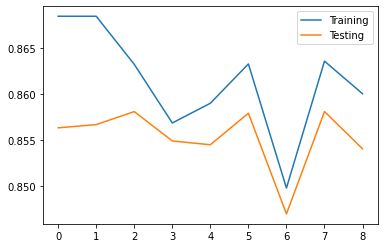

In [343]:
df_stacking.reset_index(drop=True).plot()

In [344]:
estimators = [ ('model_ada_final', model_ada_final ),
               ('bagging_KNN_bt', bagging_KNN_bt ), 
               ('model_gb_sb9', model_gb_sb9) ]

sc_best3_fest_ada = StackingClassifier(estimators=estimators, final_estimator = model_ada_final )

df_stacking = df_stacking.append( IndividualModel_Scoring( rb_X_train, y_train, 
                                                           rb_X_test, y_test, 
                                                           sc_best3_fest_ada , 'sc_best3_fest_ada', False) )

df_stacking

,Model,Scale Type,Training,Testing
0,sc_mix14_knn,no_scale,0.868458,0.856355
0,sc_mix14_knn_lr,no_scale,0.868458,0.856705
0,sc_best3,no_scale,0.863242,0.858118
0,sc_best4,minmax,0.856882,0.854932
1,sc_best4,standard,0.859022,0.854520
2,sc_best4,robust,0.863284,0.857941
0,sc_best3_fest_mix14,no_scale,0.849827,0.847018
0,sc_best3_fest_NN,no_scale,0.863587,0.858122
0,sc_best3_fest_gb,no_scale,0.860053,0.854084
0,sc_best3_fest_ada,no_scale,0.861768,0.853158


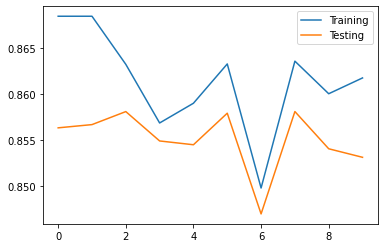

In [345]:
df_stacking.reset_index(drop=True).plot()

In [349]:
finals = [('bagging_KNN_bt', bagging_KNN_bt), ('modelRF_s_6', modelRF_s_6), ('dt_mix14', dt_mix14) ]

estimators = [ ('model_ada_final', model_ada_final ),
                   ('bagging_KNN_bt', bagging_KNN_bt ), 
                   ('model_gb_sb9', model_gb_sb9) ]

for name, FINAL in finals:

    sc_best3_fest_last = StackingClassifier(estimators=estimators, final_estimator = FINAL )
    
    text = 'sc_best3_fest_last_' + name
    
    df_stacking = df_stacking.append( IndividualModel_Scoring( rb_X_train, y_train, 
                                                               rb_X_test, y_test, 
                                                               sc_best3_fest_last , text , False) )
    
    print(name)
    
    
df_stacking

bagging_KNN_bt
modelRF_s_6
dt_mix14


,Model,Scale Type,Training,Testing
0,sc_mix14_knn,no_scale,0.868458,0.856355
0,sc_mix14_knn_lr,no_scale,0.868458,0.856705
0,sc_best3,no_scale,0.863242,0.858118
0,sc_best4,minmax,0.856882,0.854932
1,sc_best4,standard,0.859022,0.854520
2,sc_best4,robust,0.863284,0.857941
0,sc_best3_fest_mix14,no_scale,0.849827,0.847018
0,sc_best3_fest_NN,no_scale,0.863587,0.858122
0,sc_best3_fest_gb,no_scale,0.860053,0.854084
0,sc_best3_fest_ada,no_scale,0.861768,0.853158


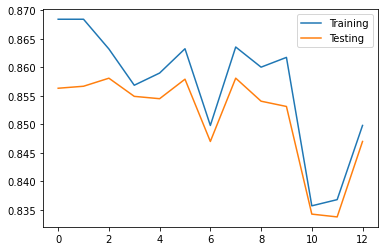

In [350]:
df_stacking.reset_index(drop=True).plot()

Let's check them without bayes that has a low performance with 4 features when compared to the rest:

In [352]:
# no bayes THIS IS THE SELECTED MODEL!!!!!!
all_estimators = [('model_gb_sb9', model_gb_sb9), 
                  ('model_ada_final', model_ada_final), 
                  ('bagging_KNN_bt' , bagging_KNN_bt), 
                  ('NN_logistic', NN_logistic), 
                  ('modelRF_s_6', modelRF_s_6), 
                  ('dt_mix14', dt_mix14), 
                  ('dt_mix13', dt_mix13)]

sc_ALL_best = StackingClassifier(estimators = all_estimators, final_estimator = LRmodel_lib )

df_stacking = df_stacking.append( IndividualModel_Scoring( rb_X_train, y_train, 
                                                           rb_X_test, y_test, 
                                                           sc_ALL_best , 'sc_ALL_best', False) )

df_stacking

,Model,Scale Type,Training,Testing
0,sc_mix14_knn,no_scale,0.868458,0.856355
0,sc_mix14_knn_lr,no_scale,0.868458,0.856705
0,sc_best3,no_scale,0.863242,0.858118
0,sc_best4,minmax,0.856882,0.854932
1,sc_best4,standard,0.859022,0.854520
2,sc_best4,robust,0.863284,0.857941
0,sc_best3_fest_mix14,no_scale,0.849827,0.847018
0,sc_best3_fest_NN,no_scale,0.863587,0.858122
0,sc_best3_fest_gb,no_scale,0.860053,0.854084
0,sc_best3_fest_ada,no_scale,0.861768,0.853158


In [353]:
all_estimators = [('bayes', modelNB),('model_gb_sb9', model_gb_sb9), 
                  ('model_ada_final', model_ada_final), 
                  ('bagging_KNN_bt' , bagging_KNN_bt), 
                  ('NN_logistic', NN_logistic), 
                  ('modelRF_s_6', modelRF_s_6), 
                  ('dt_mix14', dt_mix14), 
                  ('dt_mix13', dt_mix13)]

sc_ALL_best = StackingClassifier(estimators = all_estimators, final_estimator = LRmodel_lib )

df_stacking = df_stacking.append( IndividualModel_Scoring( rb_X_train, y_train, 
                                                           rb_X_test, y_test, 
                                                           sc_ALL_best , 'sc_ALL_best(+bayes)', False) )

df_stacking

,Model,Scale Type,Training,Testing
0,sc_mix14_knn,no_scale,0.868458,0.856355
0,sc_mix14_knn_lr,no_scale,0.868458,0.856705
0,sc_best3,no_scale,0.863242,0.858118
0,sc_best4,minmax,0.856882,0.854932
1,sc_best4,standard,0.859022,0.854520
2,sc_best4,robust,0.863284,0.857941
0,sc_best3_fest_mix14,no_scale,0.849827,0.847018
0,sc_best3_fest_NN,no_scale,0.863587,0.858122
0,sc_best3_fest_gb,no_scale,0.860053,0.854084
0,sc_best3_fest_ada,no_scale,0.861768,0.853158


One more run of all with a different final_estimator:

In [354]:
# no bayes, second best final_estimator NN
all_estimators = [('model_gb_sb9', model_gb_sb9), 
                  ('model_ada_final', model_ada_final), 
                  ('bagging_KNN_bt' , bagging_KNN_bt), 
                  ('NN_logistic', NN_logistic), 
                  ('modelRF_s_6', modelRF_s_6), 
                  ('dt_mix14', dt_mix14), 
                  ('dt_mix13', dt_mix13)]

sc_ALL_best_finNN = StackingClassifier(estimators = all_estimators, final_estimator = NN_logistic )

df_stacking = df_stacking.append( IndividualModel_Scoring( rb_X_train, y_train, 
                                                           rb_X_test, y_test, 
                                                           sc_ALL_best_finNN , 'sc_ALL_best_finNN', False) )

df_stacking

,Model,Scale Type,Training,Testing
0,sc_mix14_knn,no_scale,0.868458,0.856355
0,sc_mix14_knn_lr,no_scale,0.868458,0.856705
0,sc_best3,no_scale,0.863242,0.858118
0,sc_best4,minmax,0.856882,0.854932
1,sc_best4,standard,0.859022,0.854520
2,sc_best4,robust,0.863284,0.857941
0,sc_best3_fest_mix14,no_scale,0.849827,0.847018
0,sc_best3_fest_NN,no_scale,0.863587,0.858122
0,sc_best3_fest_gb,no_scale,0.860053,0.854084
0,sc_best3_fest_ada,no_scale,0.861768,0.853158


In [355]:
# no bayes, second best final_estimator NN
all_estimators = [('model_gb_sb9', model_gb_sb9), 
                  ('model_ada_final', model_ada_final), 
                  ('bagging_KNN_bt' , bagging_KNN_bt), 
                  ('NN_logistic', NN_logistic), 
                  ('modelRF_s_6', modelRF_s_6), 
                  ('dt_mix14', dt_mix14), 
                  ('dt_mix13', dt_mix13)]

sc_ALL_best_finGB = StackingClassifier(estimators = all_estimators, final_estimator = model_gb_sb9 )

df_stacking = df_stacking.append( IndividualModel_Scoring( rb_X_train, y_train, 
                                                           rb_X_test, y_test, 
                                                           sc_ALL_best_finGB , 'sc_ALL_best_finGB', False) )

df_stacking

,Model,Scale Type,Training,Testing
0,sc_mix14_knn,no_scale,0.868458,0.856355
0,sc_mix14_knn_lr,no_scale,0.868458,0.856705
0,sc_best3,no_scale,0.863242,0.858118
0,sc_best4,minmax,0.856882,0.854932
1,sc_best4,standard,0.859022,0.854520
2,sc_best4,robust,0.863284,0.857941
0,sc_best3_fest_mix14,no_scale,0.849827,0.847018
0,sc_best3_fest_NN,no_scale,0.863587,0.858122
0,sc_best3_fest_gb,no_scale,0.860053,0.854084
0,sc_best3_fest_ada,no_scale,0.861768,0.853158


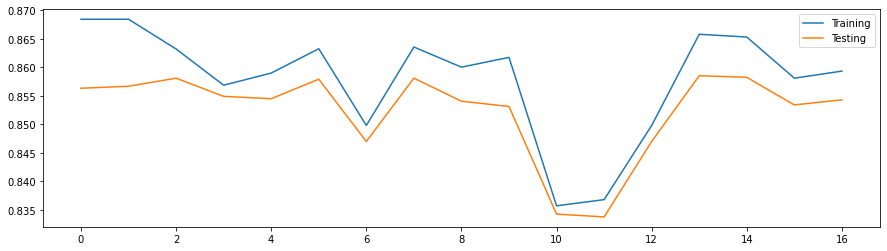

In [364]:
df_stacking.reset_index(drop = True, inplace = True)
df_stacking.plot( figsize = (15, 4) )

In [358]:
df_stacking

,Model,Scale Type,Training,Testing
0,sc_mix14_knn,no_scale,0.868458,0.856355
1,sc_mix14_knn_lr,no_scale,0.868458,0.856705
2,sc_best3,no_scale,0.863242,0.858118
3,sc_best4,minmax,0.856882,0.854932
4,sc_best4,standard,0.859022,0.854520
5,sc_best4,robust,0.863284,0.857941
6,sc_best3_fest_mix14,no_scale,0.849827,0.847018
7,sc_best3_fest_NN,no_scale,0.863587,0.858122
8,sc_best3_fest_gb,no_scale,0.860053,0.854084
9,sc_best3_fest_ada,no_scale,0.861768,0.853158


We will choose, as our final model, a stacking of all the models assessed during all the workbook without including bayes:

In [361]:
df_stacking.loc[13]

Model         sc_ALL_best
Scale Type       no_scale
Training         0.865824
Testing          0.858548
Name: 13, dtype: object

In [365]:
# THIS IS THE SELECTED MODEL!!!!!!
all_estimators = [('model_gb_sb9', model_gb_sb9), 
                  ('model_ada_final', model_ada_final), 
                  ('bagging_KNN_bt' , bagging_KNN_bt), 
                  ('NN_logistic', NN_logistic), 
                  ('modelRF_s_6', modelRF_s_6), 
                  ('dt_mix14', dt_mix14), 
                  ('dt_mix13', dt_mix13)]

sc_ALL_best = StackingClassifier(estimators = all_estimators, final_estimator = LRmodel_lib )

Let's validate with kFolds:

In [366]:
df_final = model_scores( KFold(n_splits = 10), 
                         XX, 
                         YY, 
                         sc_ALL_best,
                         RobustScaler() )

dataframe_mean_std(df_final)

,Time,Training,Test
0,183.378 +/- 20.109,0.862 +/- 0.001,0.855 +/- 0.01


### ===============================================

### Final F1:

We have our final model. Let's get the F1 weighted if we include the age records cleaned from our dataset at the begining:

In [371]:
# XX scaled
rb_XX = scaling(XX,XX)[4]

YY_pred = sc_ALL_best.fit(rb_XX, YY)

YY_pred = YY_pred.predict(rb_XX)

F1 result for the whole dataset:

In [382]:
f1_score(YY, YY_pred, average = 'weighted')

0.863161594469939

We dropped 222 minors that by default have to be 0. Let's include them and calculate the F1 for our final model:

In [386]:
Y_pred_minors = np.zeros(222)

In [388]:
print(Y_pred_minors.shape, YY_pred.shape)

(222,) (22178,)


In [391]:
YY_pred_total = np.append( YY_pred, Y_pred_minors)
YY_pred_total.shape

(22400,)

In [395]:
# Adding the zeros to the original dataset.
YY_original = np.append(YY, Y_pred_minors)

YY_original.shape

(22400,)

Calculating F1:

In [396]:
f1_score(YY_original, YY_pred_total, average = 'weighted')

0.8644893861793722

#### ======================================================================================

# Getting the predictions:

We have our model to test. Let's import our validation data:

In [417]:
dfval = pd.read_excel('Test.xlsx')
.insert(loc=3, column='Age', value=Age.values)
dfval.head()

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
0,34886,Mr. Dan Kerr,"May 13,2012",Europe,Married,Wife,Northbury,Bachelors + PostGraduation,16,Private Sector - Services,Sales,40,0,0
1,34887,Miss Olivia Grant,"August 9,2014",Europe,Single,Other Family,Northbury,Bachelors + PostGraduation,16,Private Sector - Services,Professor,36,0,0
2,34888,Mr. Trevor Simpson,"May 23,2020",Europe,Divorced,Other Family,Northbury,Professional School + PostGraduation,13,Private Sector - Services,Management,50,12940,0
3,34889,Mr. David Clark,"April 15,2016",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Professor,48,0,1827
4,34890,Mr. Gavin Lambert,"April 22,2011",Europe,Married,Wife,Watford,Bachelors,15,Public Sector - Others,Professor,45,0,0


We would need to add the needed columns to run our model:

In [418]:
# Getting the age using a parser
Age = dfval.Birthday.apply(lambda x: parse(x).date())

# Getting the date of each subject by 2044:
Age = Age.apply(lambda X: (parse('01-01-2048').date() - X ).days // 365 )

# Inserting the column in a convinient possition
dfval.insert(loc=3, column='Age', value=Age.values)

dfval.head()

,CITIZEN_ID,Name,Birthday,Age,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
0,34886,Mr. Dan Kerr,"May 13,2012",27,Europe,Married,Wife,Northbury,Bachelors + PostGraduation,16,Private Sector - Services,Sales,40,0,0
1,34887,Miss Olivia Grant,"August 9,2014",33,Europe,Single,Other Family,Northbury,Bachelors + PostGraduation,16,Private Sector - Services,Professor,36,0,0
2,34888,Mr. Trevor Simpson,"May 23,2020",27,Europe,Divorced,Other Family,Northbury,Professional School + PostGraduation,13,Private Sector - Services,Management,50,12940,0
3,34889,Mr. David Clark,"April 15,2016",27,Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Professor,48,0,1827
4,34890,Mr. Gavin Lambert,"April 22,2011",27,Europe,Married,Wife,Watford,Bachelors,15,Public Sector - Others,Professor,45,0,0


In [425]:
XX.columns.to_list()

['Lives with partner',
 'Years of Education',
 'Role (prof+manag)',
 'Working Hours per week',
 'Money Received',
 'Ticket Price',
 'Age']

In [420]:
XX.head(2)

,Lives with partner,Years of Education,Role (prof+manag),Working Hours per week,Money Received,Ticket Price,Age
0,1,13,0,40,0,2273,44
1,1,12,0,40,0,0,27


Encoding columns:

In [421]:
# Grouping to see if it is married, or not

dfval['Lives with'] = dfval['Lives with'].str.lower()
dfval['Role'] = dfval['Role'].str.lower()

# Grouping with the people that live togeter
repl_lives = {
    'wife': 1,
    'husband': 1,
    'children': 0,
    'other': 0,
    'alone': 0
}

# Grouping for the type of role (prof and management)
rep_role = {
    'professor': 1,
    'management': 1,
    'sales': 0,
    'security': 0,
    'army': 0,
    'services':0,
    'repair': 0,
    'administratives': 0,
    'machine': 0,
    'transports': 0,
    'cleaners': 0,
    'it': 0,
    'fishing': 0
}


# Manually encoding:
column_creator_encoded(dfval, repl_lives, 'Lives with', 'Lives with' + ' partner')
column_creator_encoded(dfval, rep_role, 'Role', 'Role' + ' (prof+manag)')

dfval['Role (prof+manag)'].replace({'?': 1}, inplace=True) # unknown values added to the mode of the training dataset.

Checking that the results were successful:

In [422]:
dfval['Lives with partner'].value_counts()

0    5426
1    4674
Name: Lives with partner, dtype: int64

In [423]:
dfval['Role (prof+manag)'].value_counts()

0    6985
1    3115
Name: Role (prof+manag), dtype: int64

Getting a copy:

In [450]:
XX_val_orig = dfval[ XX.columns.to_list() ].copy()
XX_val_orig.head()

,Lives with partner,Years of Education,Role (prof+manag),Working Hours per week,Money Received,Ticket Price,Age
0,1,16,0,40,0,0,27
1,0,16,1,36,0,0,33
2,0,13,1,50,12940,0,27
3,1,12,1,48,0,1827,27
4,1,15,1,45,0,0,27


#### ============================

## Starting the validation:

Getting the needed columns:

In [433]:
XX_val = dfval[ XX.columns.to_list() ]

XX_val.head()

,Lives with partner,Years of Education,Role (prof+manag),Working Hours per week,Money Received,Ticket Price,Age
0,1,16,0,40,0,0,27
1,0,16,1,36,0,0,33
2,0,13,1,50,12940,0,27
3,1,12,1,48,0,1827,27
4,1,15,1,45,0,0,27


##### Getting the minors out:

In [436]:
df_minors = XX_val[XX_val['Age'] <= 17]
n_minors = len(df_minors)

print(n_minors)
df_minors.head()

76


,Lives with partner,Years of Education,Role (prof+manag),Working Hours per week,Money Received,Ticket Price,Age
126,0,11,0,24,0,0,17
307,0,12,0,14,731,0,17
452,0,12,0,60,0,0,17
861,0,12,0,3,41937,0,17
979,0,13,0,35,0,0,17


##### Filtering over 17:

In [437]:
XX_val = XX_val[ XX_val['Age'] > 17  ]

XX_val

,Lives with partner,Years of Education,Role (prof+manag),Working Hours per week,Money Received,Ticket Price,Age
0,1,16,0,40,0,0,27
1,0,16,1,36,0,0,33
2,0,13,1,50,12940,0,27
3,1,12,1,48,0,1827,27
4,1,15,1,45,0,0,27
...,...,...,...,...,...,...,...
10095,1,17,1,60,0,2432,27
10096,0,17,1,50,122999,0,27
10097,0,13,0,15,0,0,27
10098,0,16,0,40,0,0,27


##### * Scaling:

In [438]:
rb_XX_val = pd.DataFrame( scaling(XX,XX_val)[5], columns = XX_val.columns )

rb_XX_val.head()

,Lives with partner,Years of Education,Role (prof+manag),Working Hours per week,Money Received,Ticket Price,Age
0,1.0,0.75,0.0,0.0,0.0,0.0,0.0
1,0.0,0.75,1.0,-0.8,0.0,0.0,6.0
2,0.0,0.00,1.0,2.0,12940.0,0.0,0.0
3,1.0,-0.25,1.0,1.6,0.0,1827.0,0.0
4,1.0,0.50,1.0,1.0,0.0,0.0,0.0


##### * Fitting to training:

In [439]:
rb_XX = scaling(XX,XX)[4]

Fitted_XX = sc_ALL_best.fit(rb_XX, YY)

YY_val_pred = Fitted_XX.predict(rb_XX_val)

##### Exporting the first predictions:

Now that we have our output let export it:

In [446]:
YY_val_pred_notMinor = pd.DataFrame(YY_val_pred, columns = ['Income'], index = XX_val.index)
YY_val_pred_notMinor

,Income
0,1
1,0
2,1
3,1
4,1
...,...
10095,1
10096,1
10097,0
10098,0


In [448]:
#YY_val_pred_notMinor.to_csv('Pred_notMinors.csv')

In [452]:
YY_val_pred_Minor = pd.DataFrame(np.zeros(n_minors), index = df_minors.index , columns = ['Income'])
YY_val_pred_Minor

,Income
126,0.0
307,0.0
452,0.0
861,0.0
979,0.0
...,...
9211,0.0
9704,0.0
9893,0.0
10007,0.0


In [459]:
YY_val_pred_total = YY_val_pred_Minor

YY_val_pred_total = YY_val_pred_total.append( YY_val_pred_notMinor )

In [460]:
YY_val_pred_total.reset_index(inplace=True)

YY_val_pred_total

,index,Income
0,126,0.0
1,307,0.0
2,452,0.0
3,861,0.0
4,979,0.0
...,...,...
10095,10095,1.0
10096,10096,1.0
10097,10097,0.0
10098,10098,0.0


In [461]:
YY_val_pred_total.sort_values(by='index', inplace=True)

YY_val_pred_total

,index,Income
76,0,1.0
77,1,0.0
78,2,1.0
79,3,1.0
80,4,1.0
...,...,...
10095,10095,1.0
10096,10096,1.0
10097,10097,0.0
10098,10098,0.0


In [462]:
YY_val_pred_total.reset_index(drop=True, inplace=True)

YY_val_pred_total.drop(columns=['index'], inplace = True)

YY_val_pred_total

,Income
0,1.0
1,0.0
2,1.0
3,1.0
4,1.0
...,...
10095,1.0
10096,1.0
10097,0.0
10098,0.0


In [463]:
#YY_val_pred_total.to_csv('Pred_TOTAL.csv')

Validating that the minors did get a 0:

In [464]:
XX_val_orig['Income'] = YY_val_pred_total.values

In [469]:
df_makeSure = XX_val_orig[['Age', 'Income']]

df_makeSure = df_makeSure[df_makeSure['Age']<=17]

df_makeSure.Income.value_counts()

0.0    76
Name: Income, dtype: int64

In [471]:
YY_val_pred_total.Income.value_counts()

0.0    8199
1.0    1901
Name: Income, dtype: int64

In [472]:
dfval0 = pd.read_excel('Test.xlsx')

YY_val_pred_total.insert(loc=0, column='CITIZEN_ID', value = dfval0['CITIZEN_ID'].values)

YY_val_pred_total

,CITIZEN_ID,Income
0,34886,1.0
1,34887,0.0
2,34888,1.0
3,34889,1.0
4,34890,1.0
...,...,...
10095,44981,1.0
10096,44982,1.0
10097,44983,0.0
10098,44984,0.0


In [473]:
#YY_val_pred_total.to_csv('Group32_Version01.csv', index = False)

Kaggle acepts only int dtype columns.

Let's transform it:

In [477]:
YY_val_pred_total.dtypes

CITIZEN_ID      int64
Income        float64
dtype: object

In [478]:
# Creating a copy, to be safe:

YY_val_pred_total_dtype_changed = YY_val_pred_total.copy()

In [479]:
for column in YY_val_pred_total_dtype_changed.columns:
    
    YY_val_pred_total_dtype_changed[column] = YY_val_pred_total_dtype_changed[column].astype(int)

In [480]:
YY_val_pred_total_dtype_changed.dtypes

CITIZEN_ID    int32
Income        int32
dtype: object

In [481]:
YY_val_pred_total_dtype_changed.to_csv('Group32_Version02.csv', index = False)